# Hierarchical clustering

In [2]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.1.2 statsmodels==0.13.2 pynndescent==0.5.7


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


## HLCA scANVI

In [3]:
adata_hlca = sc.read("../datasets/hlca.h5ad")

In [24]:
methods_to_paths = {
    "wilcoxon_DE": "differential_expression/hlca_DE_cell_types.csv",
    "absolute_sum_expected_gradients": "expected_gradients/task_2_absolute_sum_expected_grads.csv",
    "sum_expected_gradients": "expected_gradients/task_2_sum_expected_grads.csv",
    "absolute_sum_integrated_gradients": "integrated_gradients/task_2_absolute_sum_integrated_grads.csv",
    "sum_integrated_gradients": "integrated_gradients/task_2_sum_integrated_grads.csv",
    "lime_absolute": "lime/lime_absolute.csv",
    "lime": "lime/lime.csv",
    "random": "random/task2_random.csv",
    "mean": "random/task2_mean.csv",
#     "ablation": "ablation/task2.csv"
}

results_df = pd.DataFrame(index=list(adata_hlca.var_names),
                          columns=methods_to_paths.keys())

1. Do it manually for one cell type
2. Loop through all cell types -> create one DF per cell type
3. Make the values absolute
3. Loop through all cell type DFs -> calculate spearman
4. Loop through all cell types -> clustermap

### Manual for one cell type

In [11]:
AT2_df = pd.DataFrame(index=list(adata_hlca.var_names),
                      columns=methods_to_paths.keys())

In [12]:
for method, path in methods_to_paths.items():
    method_df = pd.read_csv(f"../outputs/{path}",
                            index_col=0)
    AT2_df[method] = method_df["AT2"]
    

In [13]:
AT2_df

wilcoxon_DE  absolute_sum_expected_gradients  \
FGR             0.000000e+00                       115.908590   
CFH             0.000000e+00                        31.934937   
HS3ST1          0.000000e+00                        27.574543   
TMEM176A       4.985914e-129                        34.460100   
TFPI            0.000000e+00                       310.259400   
...                      ...                              ...   
AC133644.2      2.473566e-09                         5.515862   
TRG-AS1         5.451594e-49                        12.548523   
CH17-262H11.1   9.819694e-01                         0.015236   
RP1-34B20.21    1.507245e-05                         4.163102   
TRBV6-2         7.369878e-01                         0.299072   

               sum_expected_gradients  absolute_sum_integrated_gradients  \
FGR                          7.376847                       2.697911e+00   
CFH                          2.381531                       4.468500e+00   
HS3ST1                       7.219399                       7.567664e+00   
TMEM176A                    -6.832278                       2.842184e+00   
TFPI                      -111.135216                       1.754265e+01   
...                               ...                                ...   
AC133644.2                  -0.832906                       2.634362e-01   
TRG-AS1                     -1.209370                       1.116849e-01   
CH17-262H11.1               -0.003316                       3.895973e-07   
RP1-34B20.21                 0.702043                       5.562535e-01   
TRBV6-2                     -0.019587                       8.601373e-03   

               sum_integrated_gradients  lime_absolute      lime  random  \
FGR                       -1.187900e+00       0.008885 -0.001859     587   
CFH                       -3.315240e+00       0.008729 -0.003254     499   
HS3ST1                    -7.477320e+00       0.012887  0.008515    1869   
TMEM176A                   2.386844e+00       0.016719 -0.004692     431   
TFPI                      -4.512490e+00       0.007817  0.000589    1931   
...                                 ...            ...       ...     ...   
AC133644.2                -6.486013e-02       0.031064 -0.004183     258   
TRG-AS1                    5.102680e-02       0.022201  0.001556     937   
CH17-262H11.1              3.708296e-07       0.013852  0.000343     192   
RP1-34B20.21              -4.431773e-01       0.028561  0.007402    1113   
TRBV6-2                   -8.595383e-03       0.095032  0.003462      14   

                   mean      ablation  
FGR            0.017336 -8.821488e-07  
CFH            0.049566  0.000000e+00  
HS3ST1         0.003451  0.000000e+00  
TMEM176A       0.008798  0.000000e+00  
TFPI           1.196553 -1.287460e-06  
...                 ...           ...  
AC133644.2     0.000843  0.000000e+00  
TRG-AS1        0.001367  0.000000e+00  
CH17-262H11.1  0.000108  0.000000e+00  
RP1-34B20.21   0.004518  0.000000e+00  
TRBV6-2        0.000069  0.000000e+00  

[2000 rows x 10 columns]

In [14]:
AT2_df.apply(lambda df: df.abs())

wilcoxon_DE  absolute_sum_expected_gradients  \
FGR             0.000000e+00                       115.908590   
CFH             0.000000e+00                        31.934937   
HS3ST1          0.000000e+00                        27.574543   
TMEM176A       4.985914e-129                        34.460100   
TFPI            0.000000e+00                       310.259400   
...                      ...                              ...   
AC133644.2      2.473566e-09                         5.515862   
TRG-AS1         5.451594e-49                        12.548523   
CH17-262H11.1   9.819694e-01                         0.015236   
RP1-34B20.21    1.507245e-05                         4.163102   
TRBV6-2         7.369878e-01                         0.299072   

               sum_expected_gradients  absolute_sum_integrated_gradients  \
FGR                          7.376847                       2.697911e+00   
CFH                          2.381531                       4.468500e+00   
HS3ST1                       7.219399                       7.567664e+00   
TMEM176A                     6.832278                       2.842184e+00   
TFPI                       111.135216                       1.754265e+01   
...                               ...                                ...   
AC133644.2                   0.832906                       2.634362e-01   
TRG-AS1                      1.209370                       1.116849e-01   
CH17-262H11.1                0.003316                       3.895973e-07   
RP1-34B20.21                 0.702043                       5.562535e-01   
TRBV6-2                      0.019587                       8.601373e-03   

               sum_integrated_gradients  lime_absolute      lime  random  \
FGR                        1.187900e+00       0.008885  0.001859     587   
CFH                        3.315240e+00       0.008729  0.003254     499   
HS3ST1                     7.477320e+00       0.012887  0.008515    1869   
TMEM176A                   2.386844e+00       0.016719  0.004692     431   
TFPI                       4.512490e+00       0.007817  0.000589    1931   
...                                 ...            ...       ...     ...   
AC133644.2                 6.486013e-02       0.031064  0.004183     258   
TRG-AS1                    5.102680e-02       0.022201  0.001556     937   
CH17-262H11.1              3.708296e-07       0.013852  0.000343     192   
RP1-34B20.21               4.431773e-01       0.028561  0.007402    1113   
TRBV6-2                    8.595383e-03       0.095032  0.003462      14   

                   mean      ablation  
FGR            0.017336  8.821488e-07  
CFH            0.049566  0.000000e+00  
HS3ST1         0.003451  0.000000e+00  
TMEM176A       0.008798  0.000000e+00  
TFPI           1.196553  1.287460e-06  
...                 ...           ...  
AC133644.2     0.000843  0.000000e+00  
TRG-AS1        0.001367  0.000000e+00  
CH17-262H11.1  0.000108  0.000000e+00  
RP1-34B20.21   0.004518  0.000000e+00  
TRBV6-2        0.000069  0.000000e+00  

[2000 rows x 10 columns]

In [15]:
AT2_spearman = AT2_df.corr(method="spearman")

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/seaborn/matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


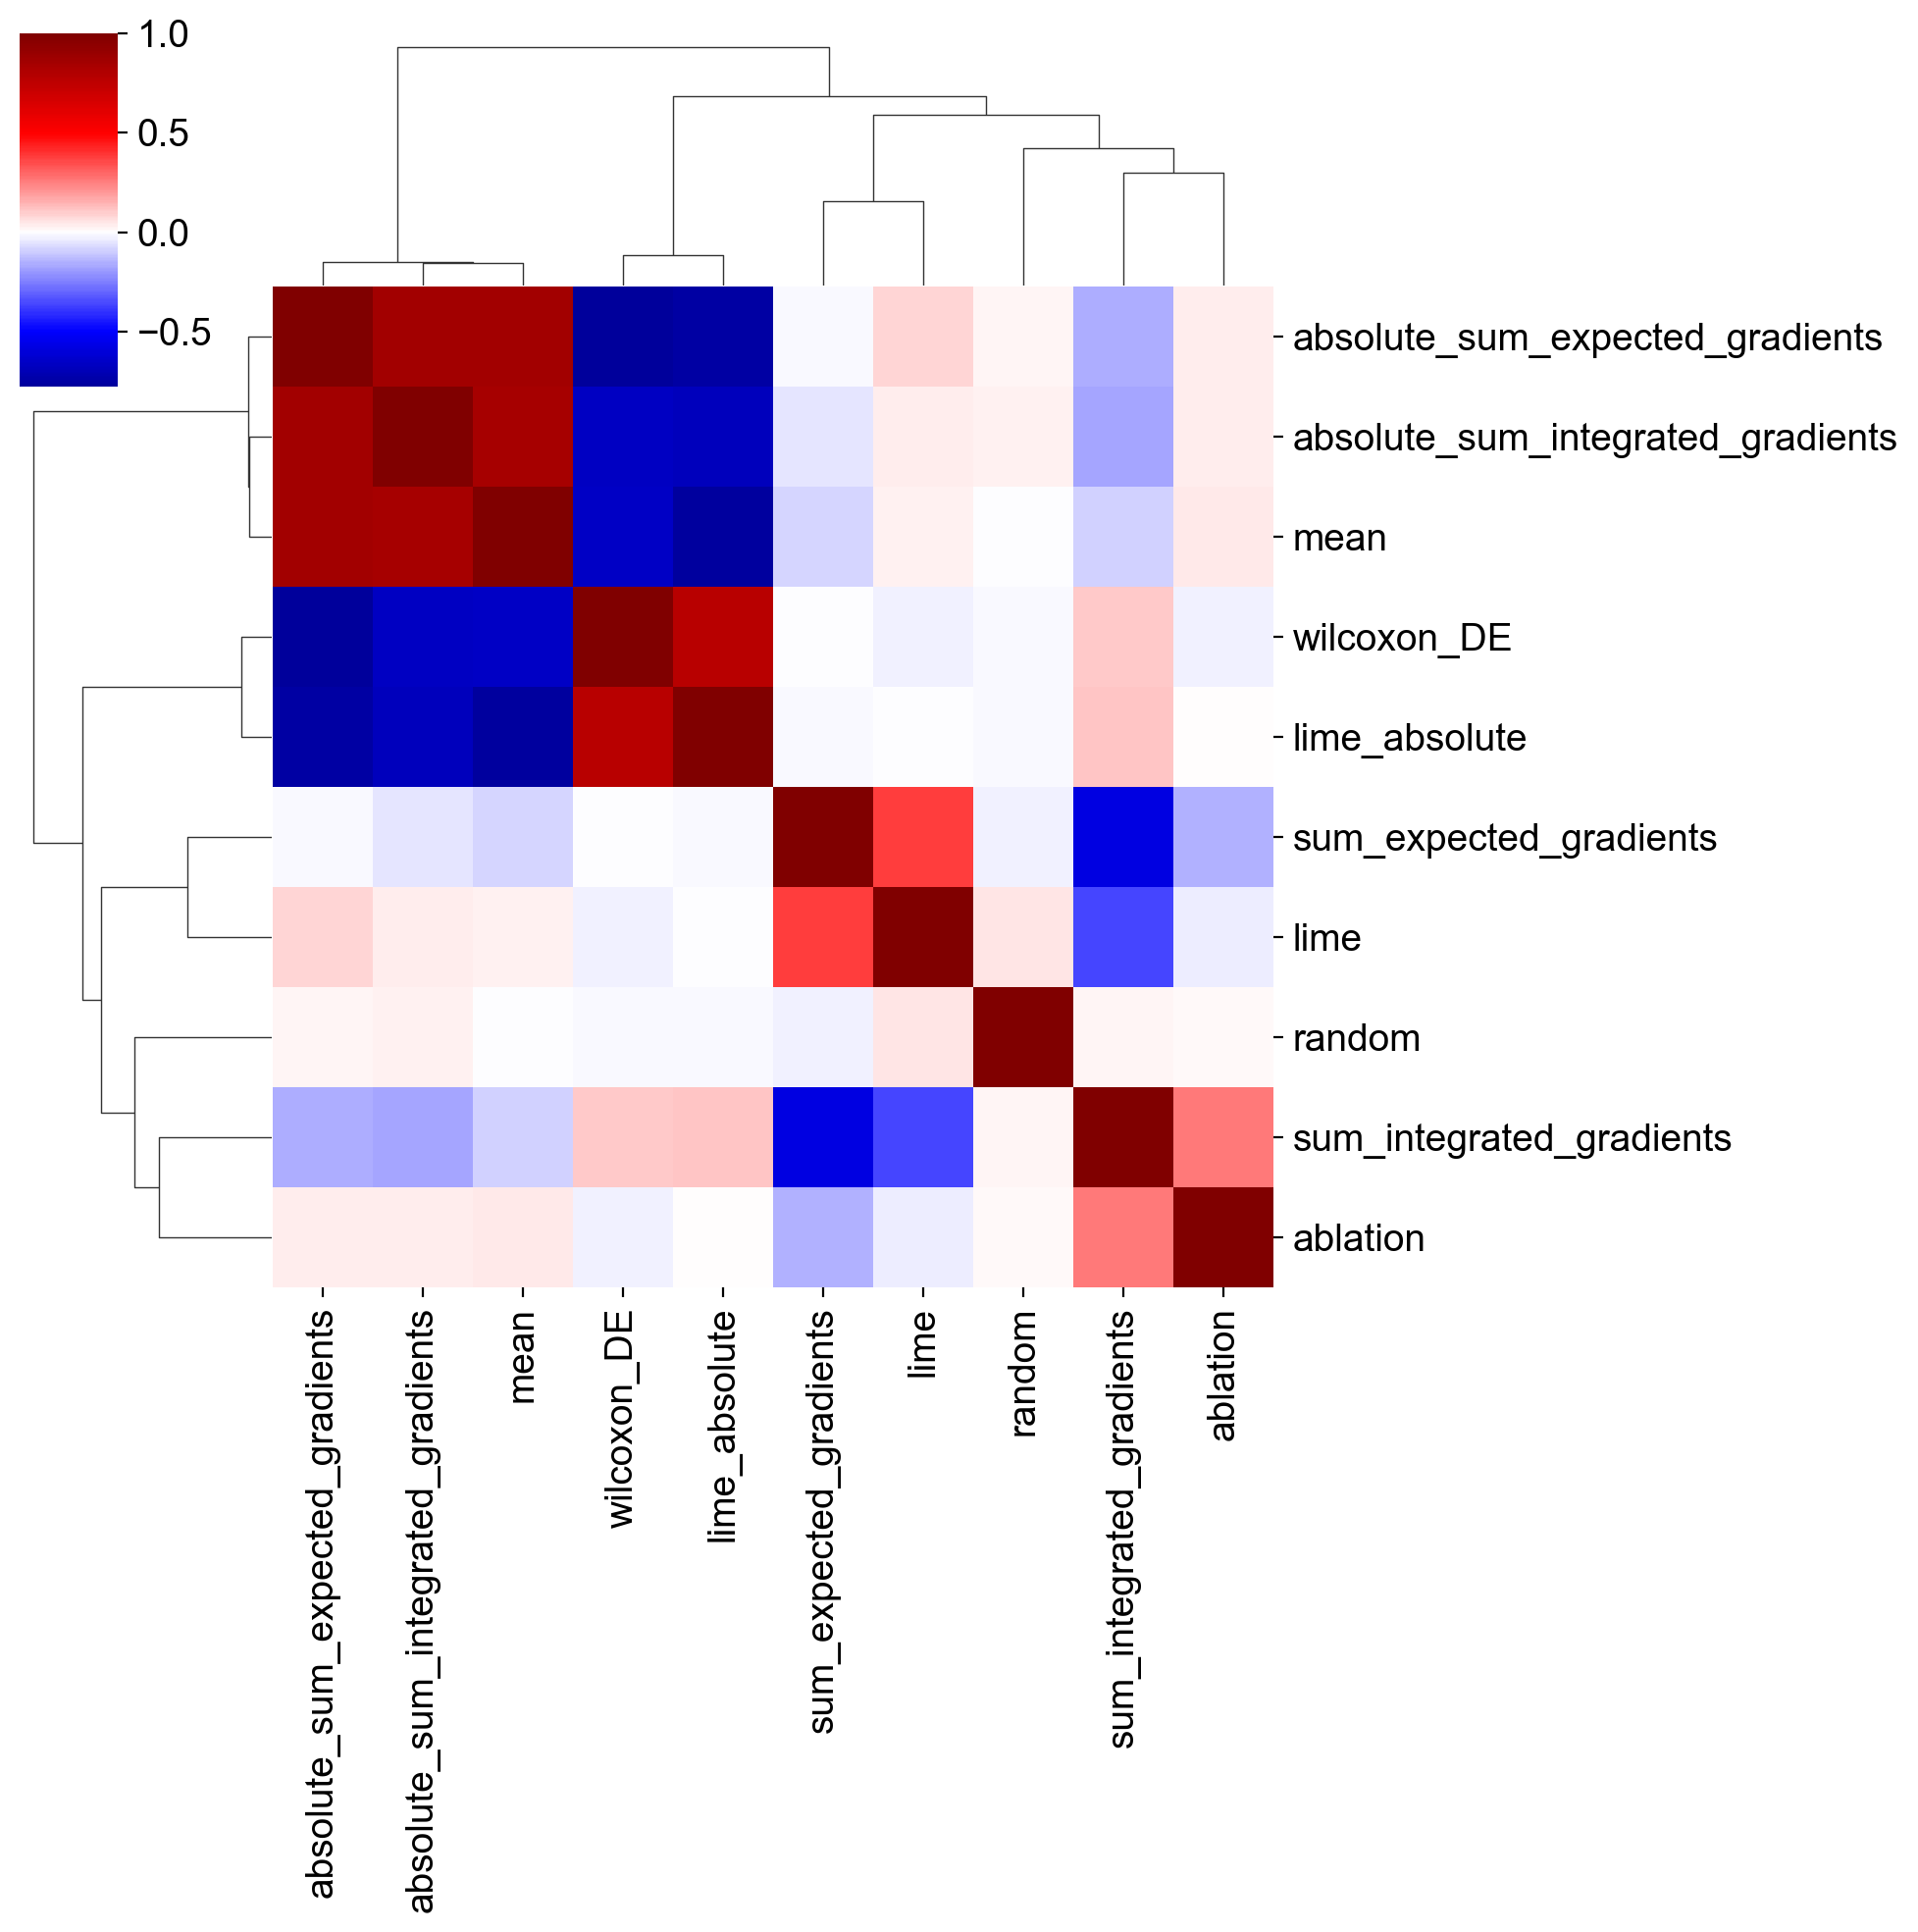

In [16]:
sns.clustermap(AT2_spearman, cmap="seismic", center=0.00)

## Loop through all cell types

In [22]:
# use ablation as the result with default celltypes
default_df = pd.read_csv(f"../outputs/{methods_to_paths['ablation']}", index_col=0)

In [74]:
pd.read_csv(f"../outputs/{methods_to_paths['wilcoxon_DE']}", index_col=0)

Basal resting    Suprabasal  Hillock-like  Deuterosomal  \
FGR             0.000000e+00  0.000000e+00  3.520118e-96  4.864790e-23   
CFH             0.000000e+00  0.000000e+00  0.000000e+00  2.319820e-03   
HS3ST1          1.186760e-01  0.000000e+00  0.000000e+00  6.066433e-10   
TMEM176A       1.797193e-101  1.042720e-88  1.982877e-12  4.854697e-03   
TFPI            0.000000e+00  8.671482e-13  6.054246e-08  5.941578e-01   
...                      ...           ...           ...           ...   
AC133644.2      2.705562e-06  4.164794e-02  3.596786e-01  5.272691e-01   
TRG-AS1         5.674926e-34  2.887433e-34  5.117745e-05  5.611918e-02   
CH17-262H11.1   9.937332e-01  9.860815e-01  9.954956e-01  9.979021e-01   
RP1-34B20.21    1.654620e-01  2.623762e-61  8.897650e-05  2.389411e-05   
TRBV6-2         7.757101e-01  7.691767e-01  9.243432e-01  9.647219e-01   

               Multiciliated (nasal)  Multiciliated (non-nasal)  \
FGR                    4.402165e-108               0.000000e+00   
CFH                     1.138924e-70              9.055552e-188   
HS3ST1                  1.572637e-51               0.000000e+00   
TMEM176A                2.080502e-10               2.555872e-03   
TFPI                   4.463345e-139               0.000000e+00   
...                              ...                        ...   
AC133644.2              1.248333e-01               1.326781e-05   
TRG-AS1                 6.410243e-05               5.932132e-27   
CH17-262H11.1           9.953647e-01               9.871933e-01   
RP1-34B20.21            4.423761e-01               5.700044e-01   
TRBV6-2                 9.419591e-01               8.239792e-01   

               Club (non-nasal)  Club (nasal)  Goblet (nasal)  \
FGR               6.955734e-220  0.000000e+00    0.000000e+00   
CFH               4.652612e-140  0.000000e+00    0.000000e+00   
HS3ST1             0.000000e+00  0.000000e+00    0.000000e+00   
TMEM176A           2.262899e-05  3.929432e-70    6.954431e-82   
TFPI              5.064091e-142  0.000000e+00    0.000000e+00   
...                         ...           ...             ...   
AC133644.2         1.787214e-02  1.610819e-04    1.498638e-04   
TRG-AS1            3.181852e-09  1.454554e-22    1.007302e-30   
CH17-262H11.1      9.933429e-01  9.890734e-01    9.870761e-01   
RP1-34B20.21       1.824830e-01  1.374974e-03    4.715729e-02   
TRBV6-2            8.883828e-01  8.434814e-01    7.852525e-01   

               Goblet (bronchial)  ...  Plasmacytoid DCs  \
FGR                  1.043059e-35  ...      2.865222e-10   
CFH                  2.798594e-64  ...      1.634267e-14   
HS3ST1              1.422899e-169  ...      4.082275e-02   
TMEM176A             1.564321e-01  ...      2.287678e-02   
TFPI                 2.711330e-03  ...      1.000339e-13   
...                           ...  ...               ...   
AC133644.2           4.649765e-01  ...      8.243043e-01   
TRG-AS1              1.729283e-02  ...      3.458579e-01   
CH17-262H11.1        9.972928e-01  ...      9.984450e-01   
RP1-34B20.21         2.146372e-20  ...      4.493140e-01   
TRBV6-2              9.544854e-01  ...      9.738481e-01   

               Alveolar macrophages  Alveolar Mph CCL3+  \
FGR                    0.000000e+00        0.000000e+00   
CFH                    0.000000e+00       2.323187e-182   
HS3ST1                 0.000000e+00        2.500814e-88   
TMEM176A               7.705299e-01        6.606670e-01   
TFPI                   0.000000e+00       3.125987e-147   
...                             ...                 ...   
AC133644.2             2.643830e-06        7.126576e-01   
TRG-AS1               2.713522e-158       6.103252e-298   
CH17-262H11.1          9.928157e-01        9.904869e-01   
RP1-34B20.21           1.571828e-03        3.615699e-02   
TRBV6-2                7.081464e-01        8.996370e-01   

               Alveolar Mph MT-positive  Alveolar Mph proliferating  \
FGR                       1.362915e-173

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/seaborn/matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


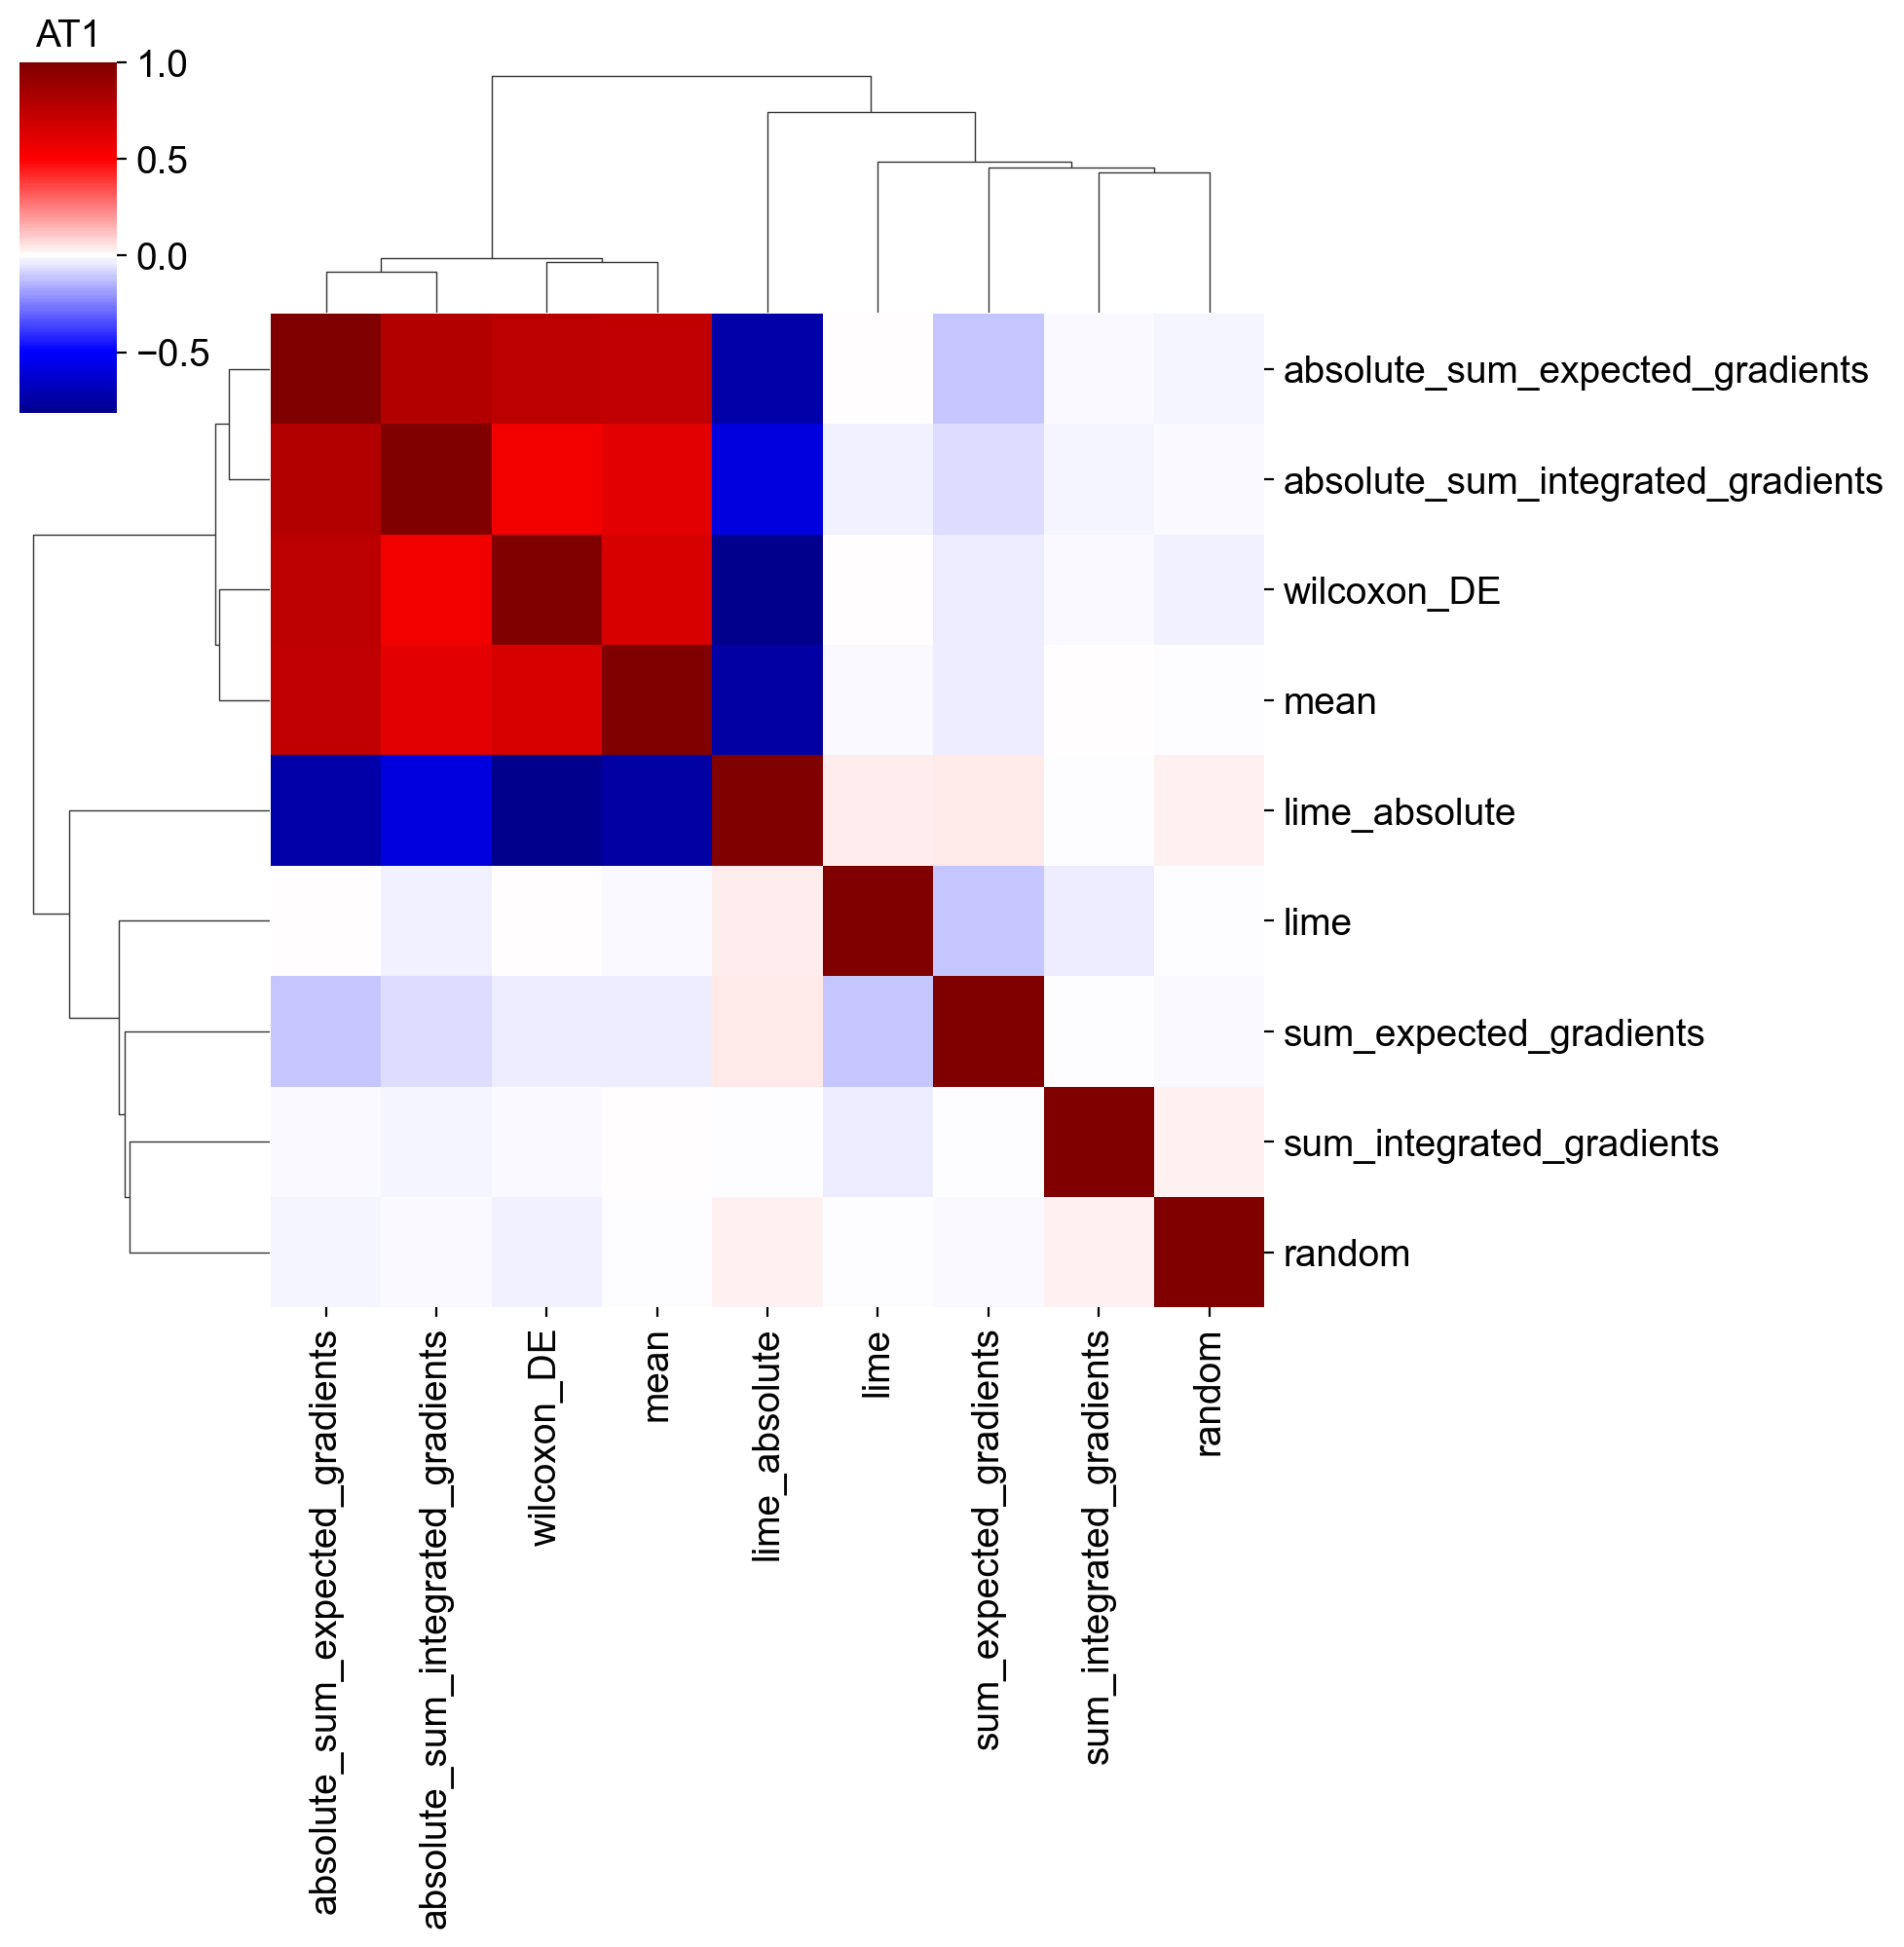

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/seaborn/matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


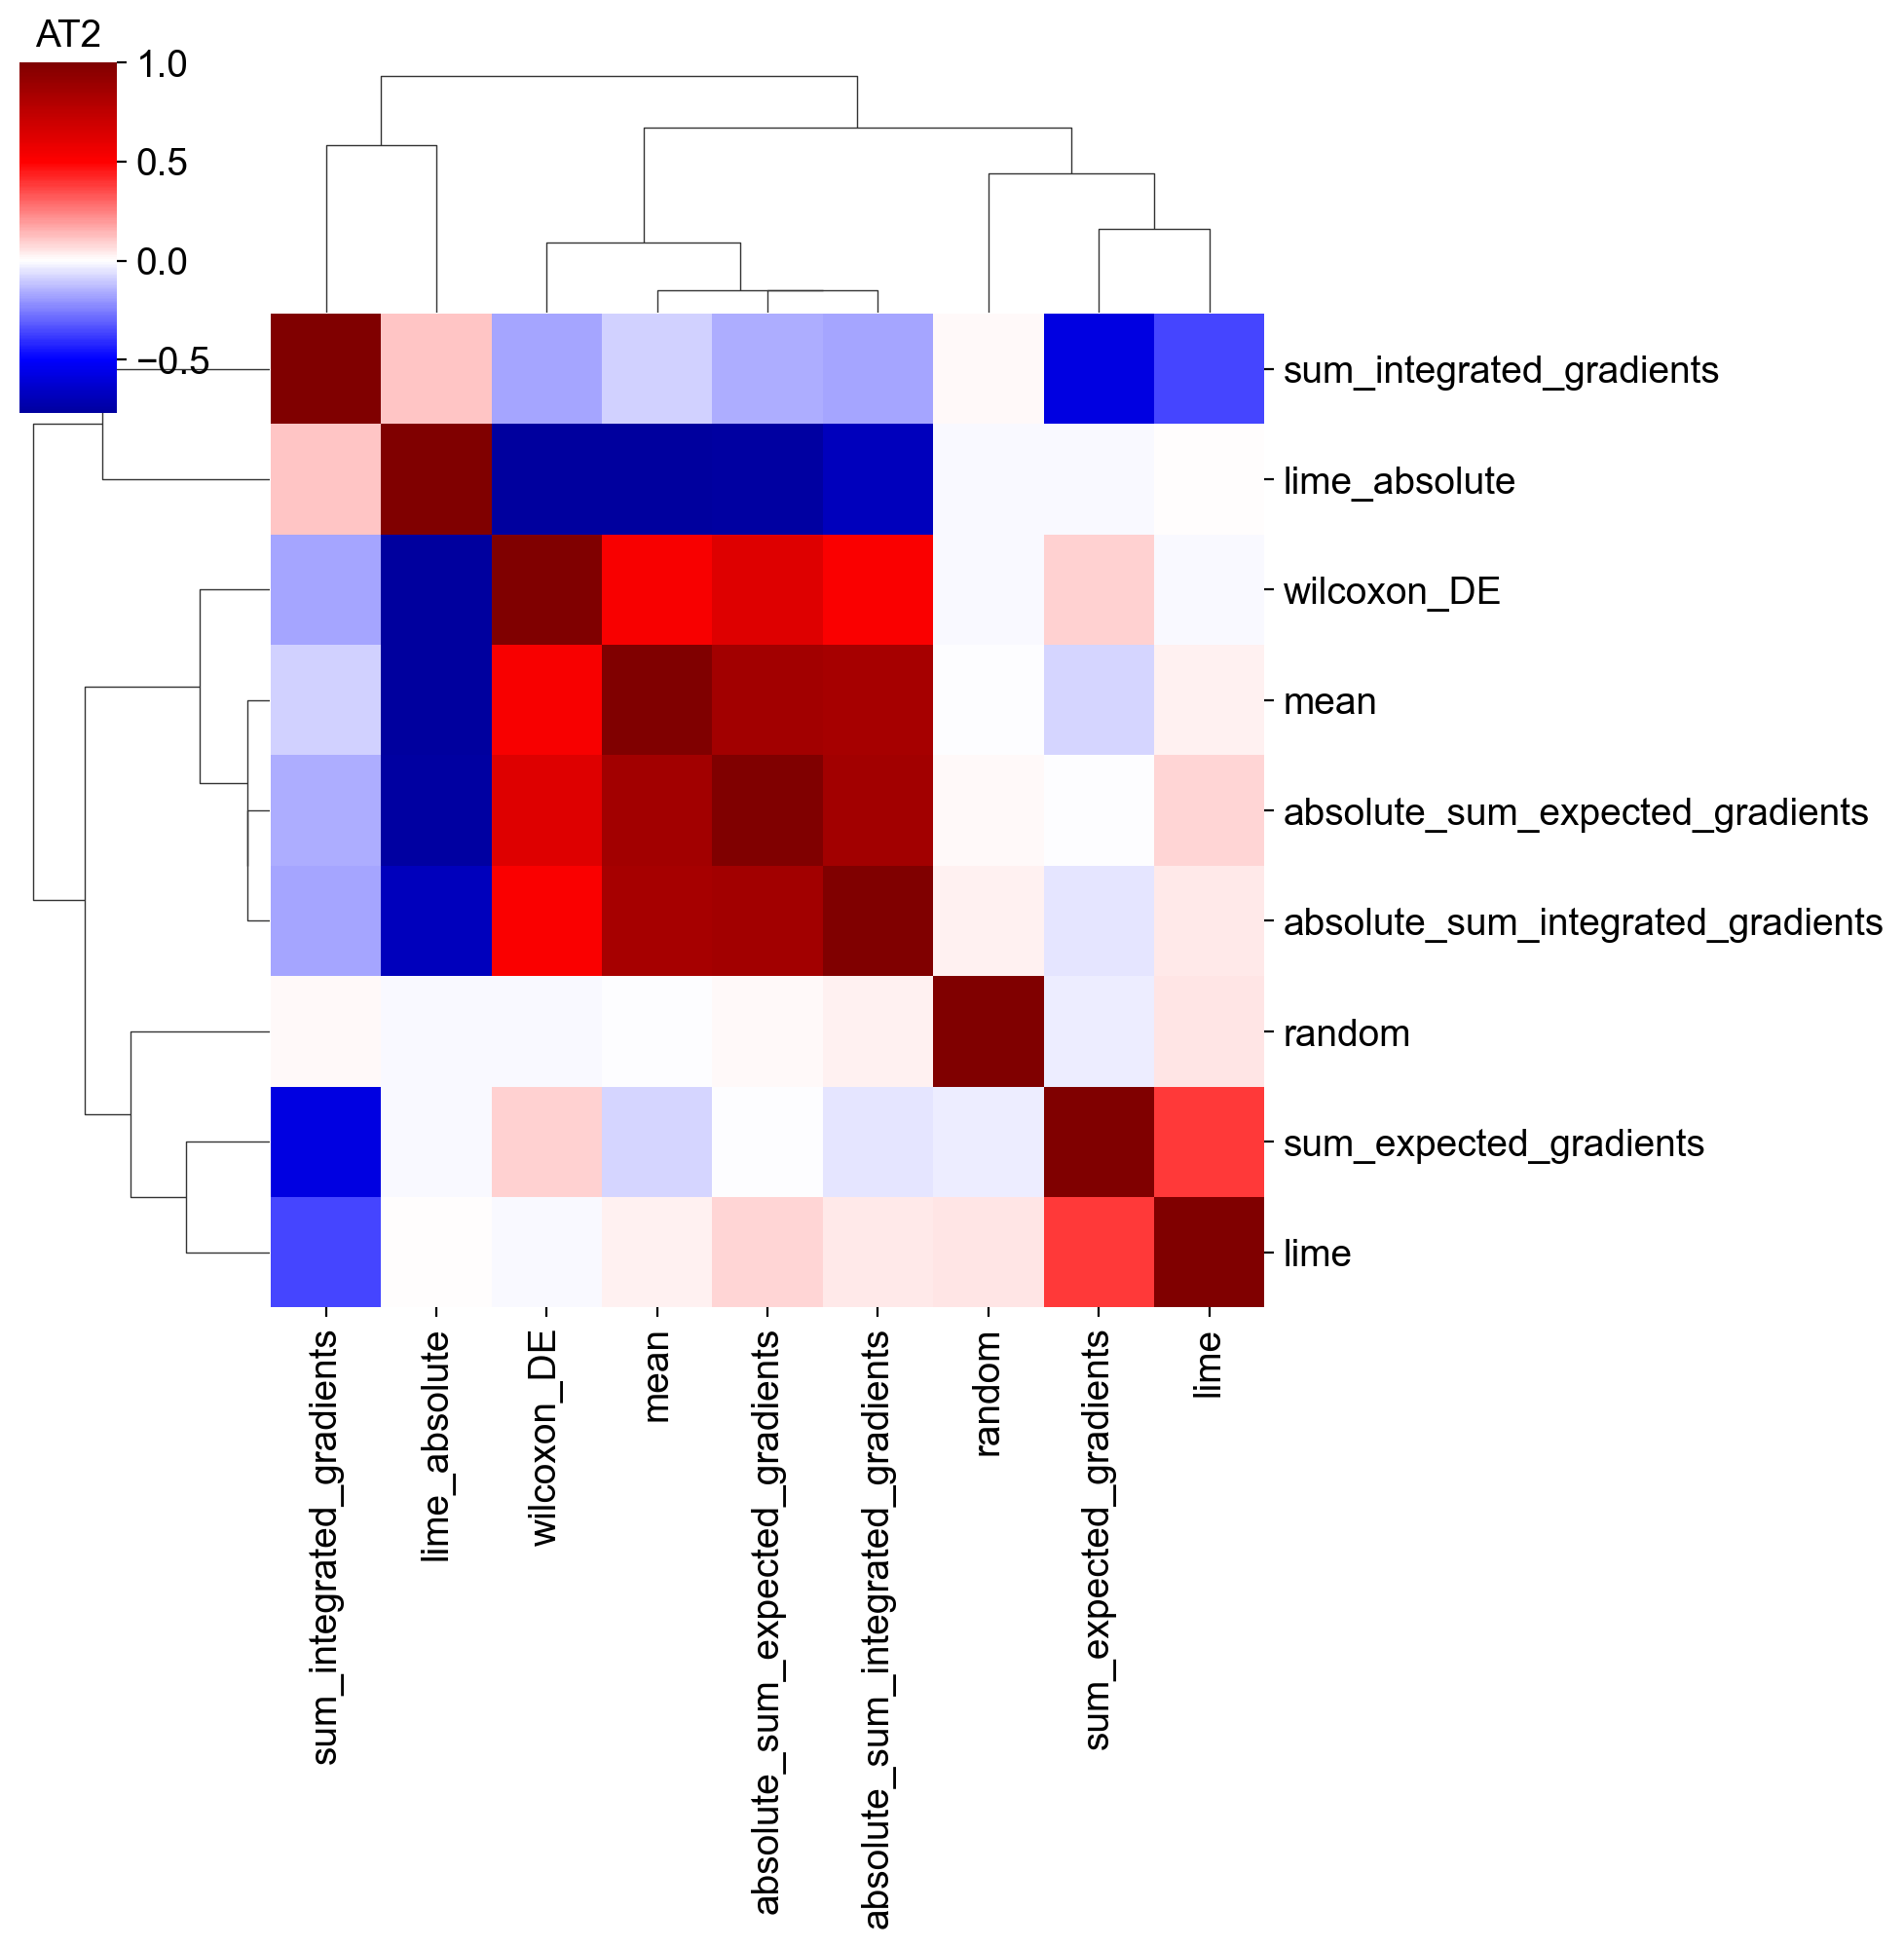

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwa

wilcoxon_DE Arterial EC
wilcoxon_DE B cell lineage
wilcoxon_DE Basal
wilcoxon_DE Bronchial Vessel 1
wilcoxon_DE Bronchial Vessel 2
wilcoxon_DE Capillary
wilcoxon_DE Ciliated
wilcoxon_DE Dendritic cells
wilcoxon_DE Fibroblast lineage


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


wilcoxon_DE KRT5- KRT17+ epithelial
wilcoxon_DE Lymphatic EC
wilcoxon_DE Macrophages


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/seaborn/matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


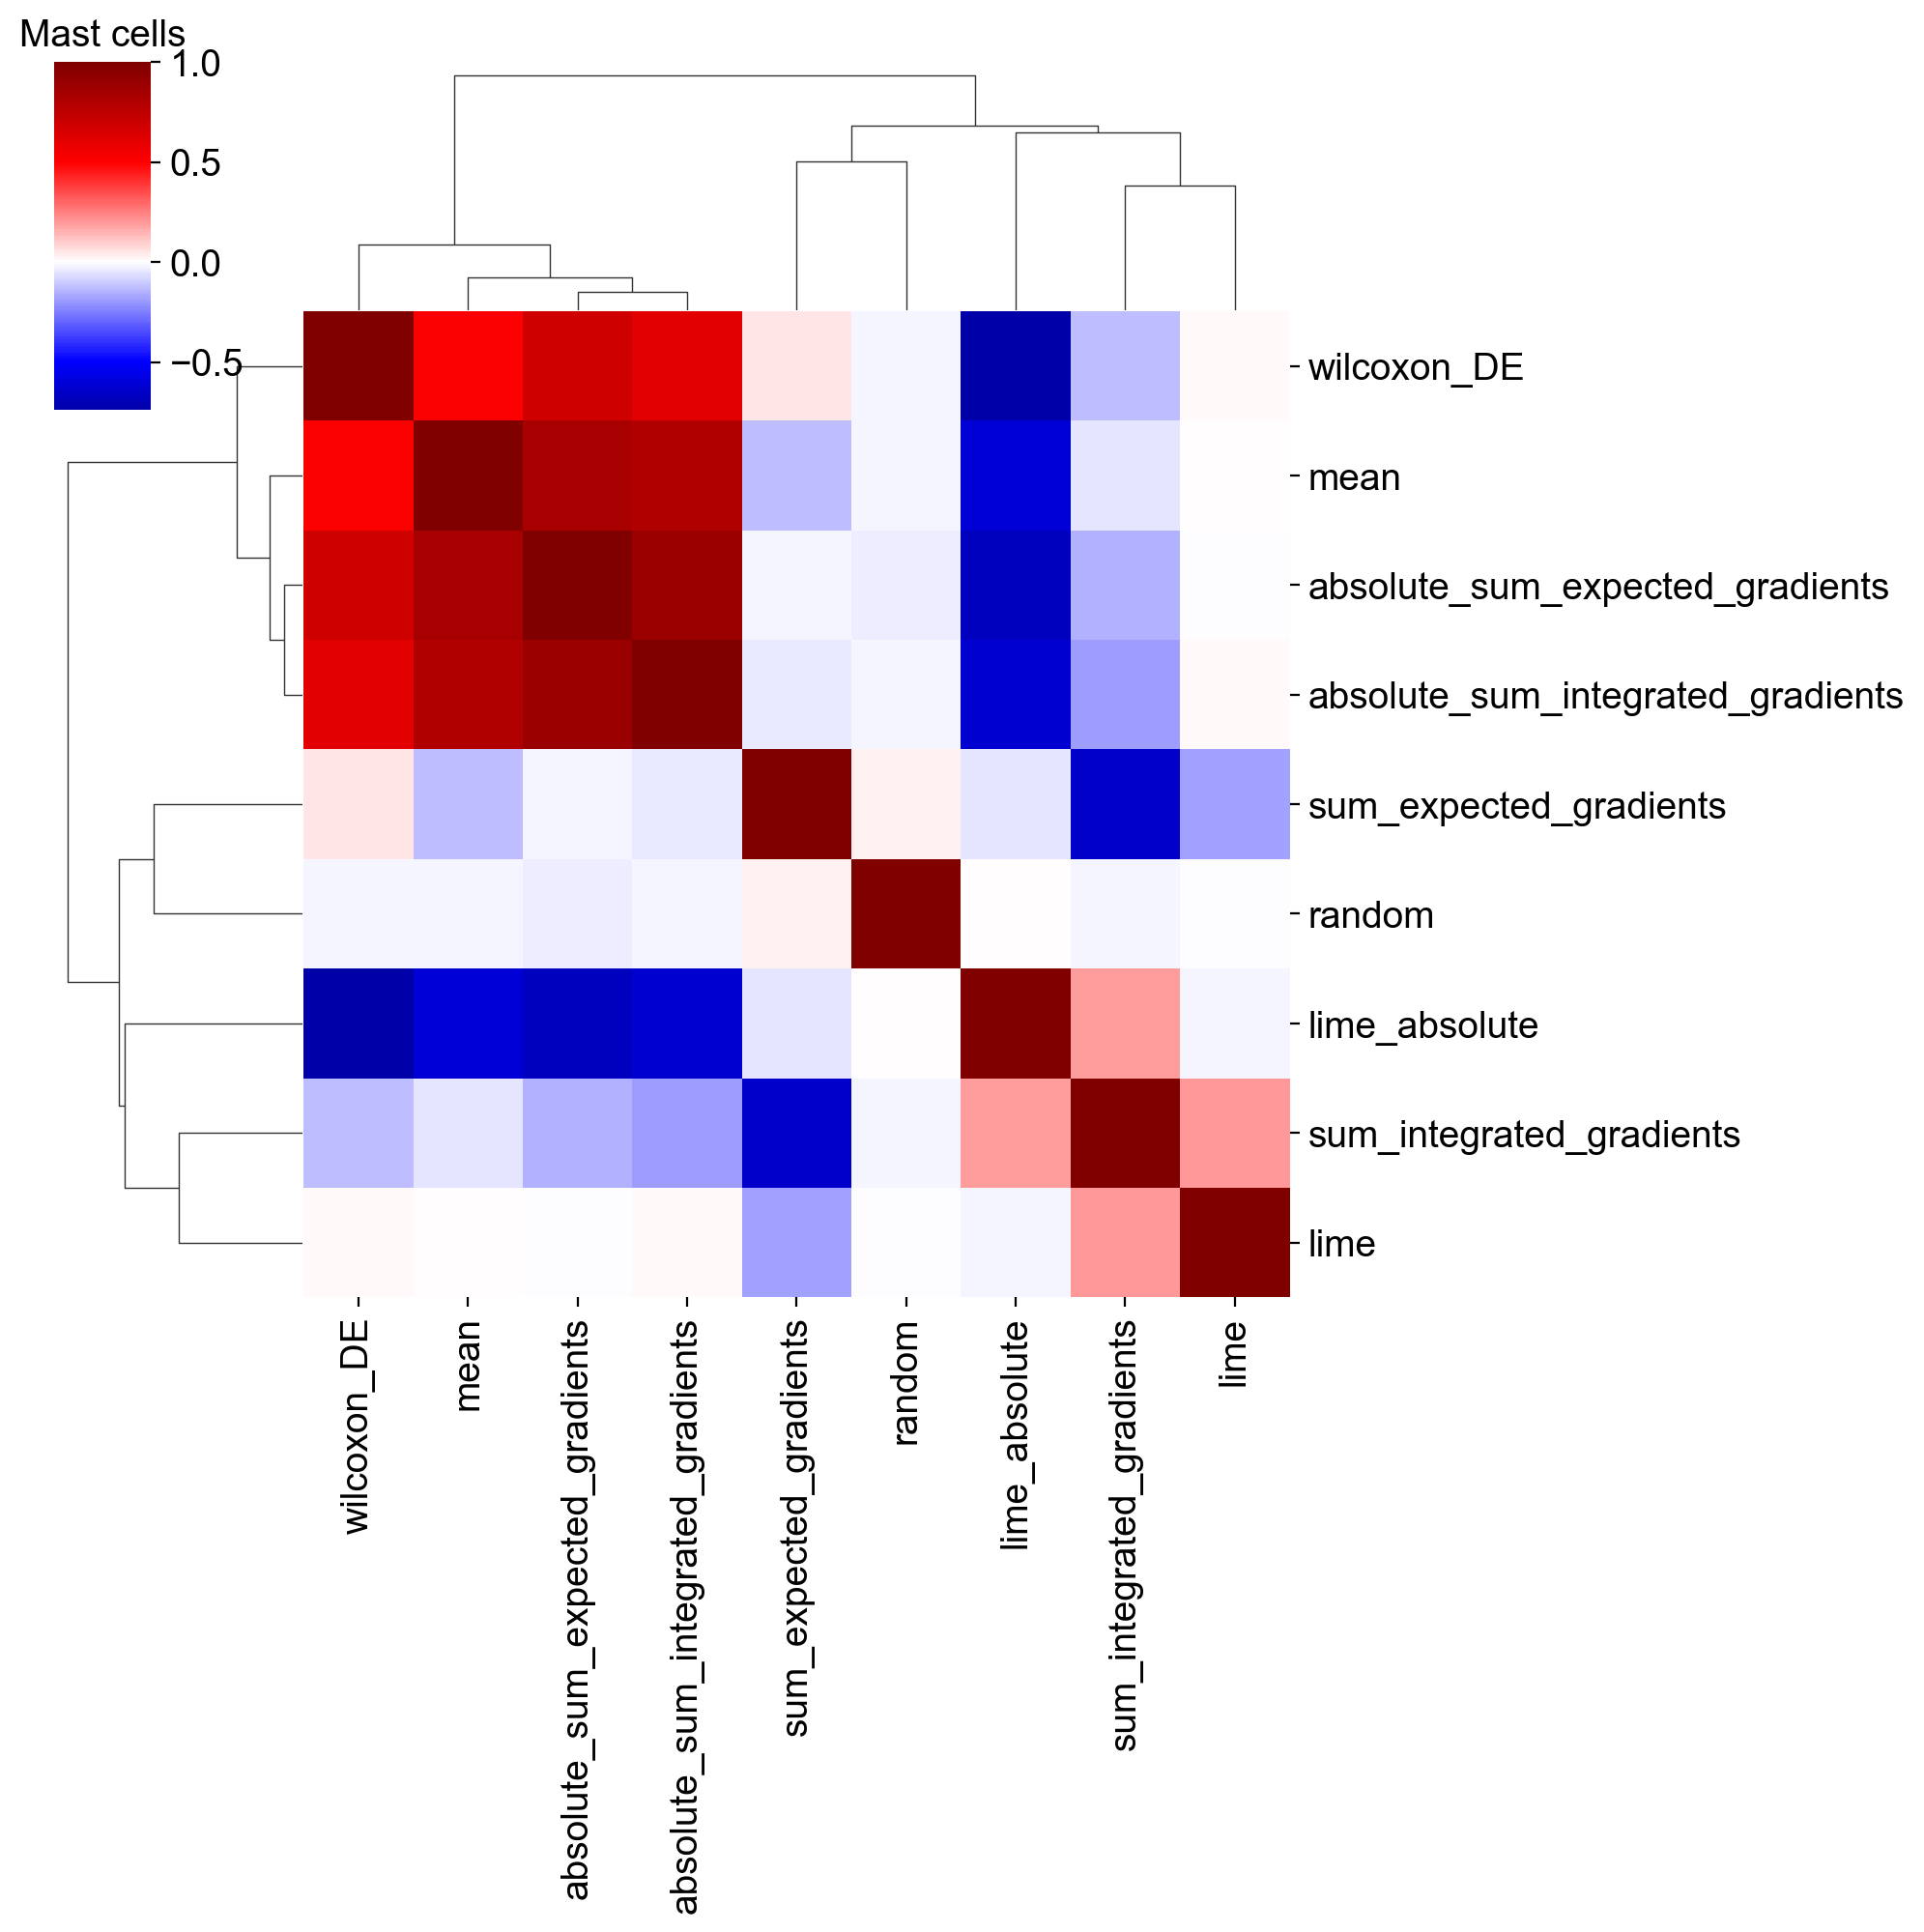

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


wilcoxon_DE Megakaryocytes


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/seaborn/matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


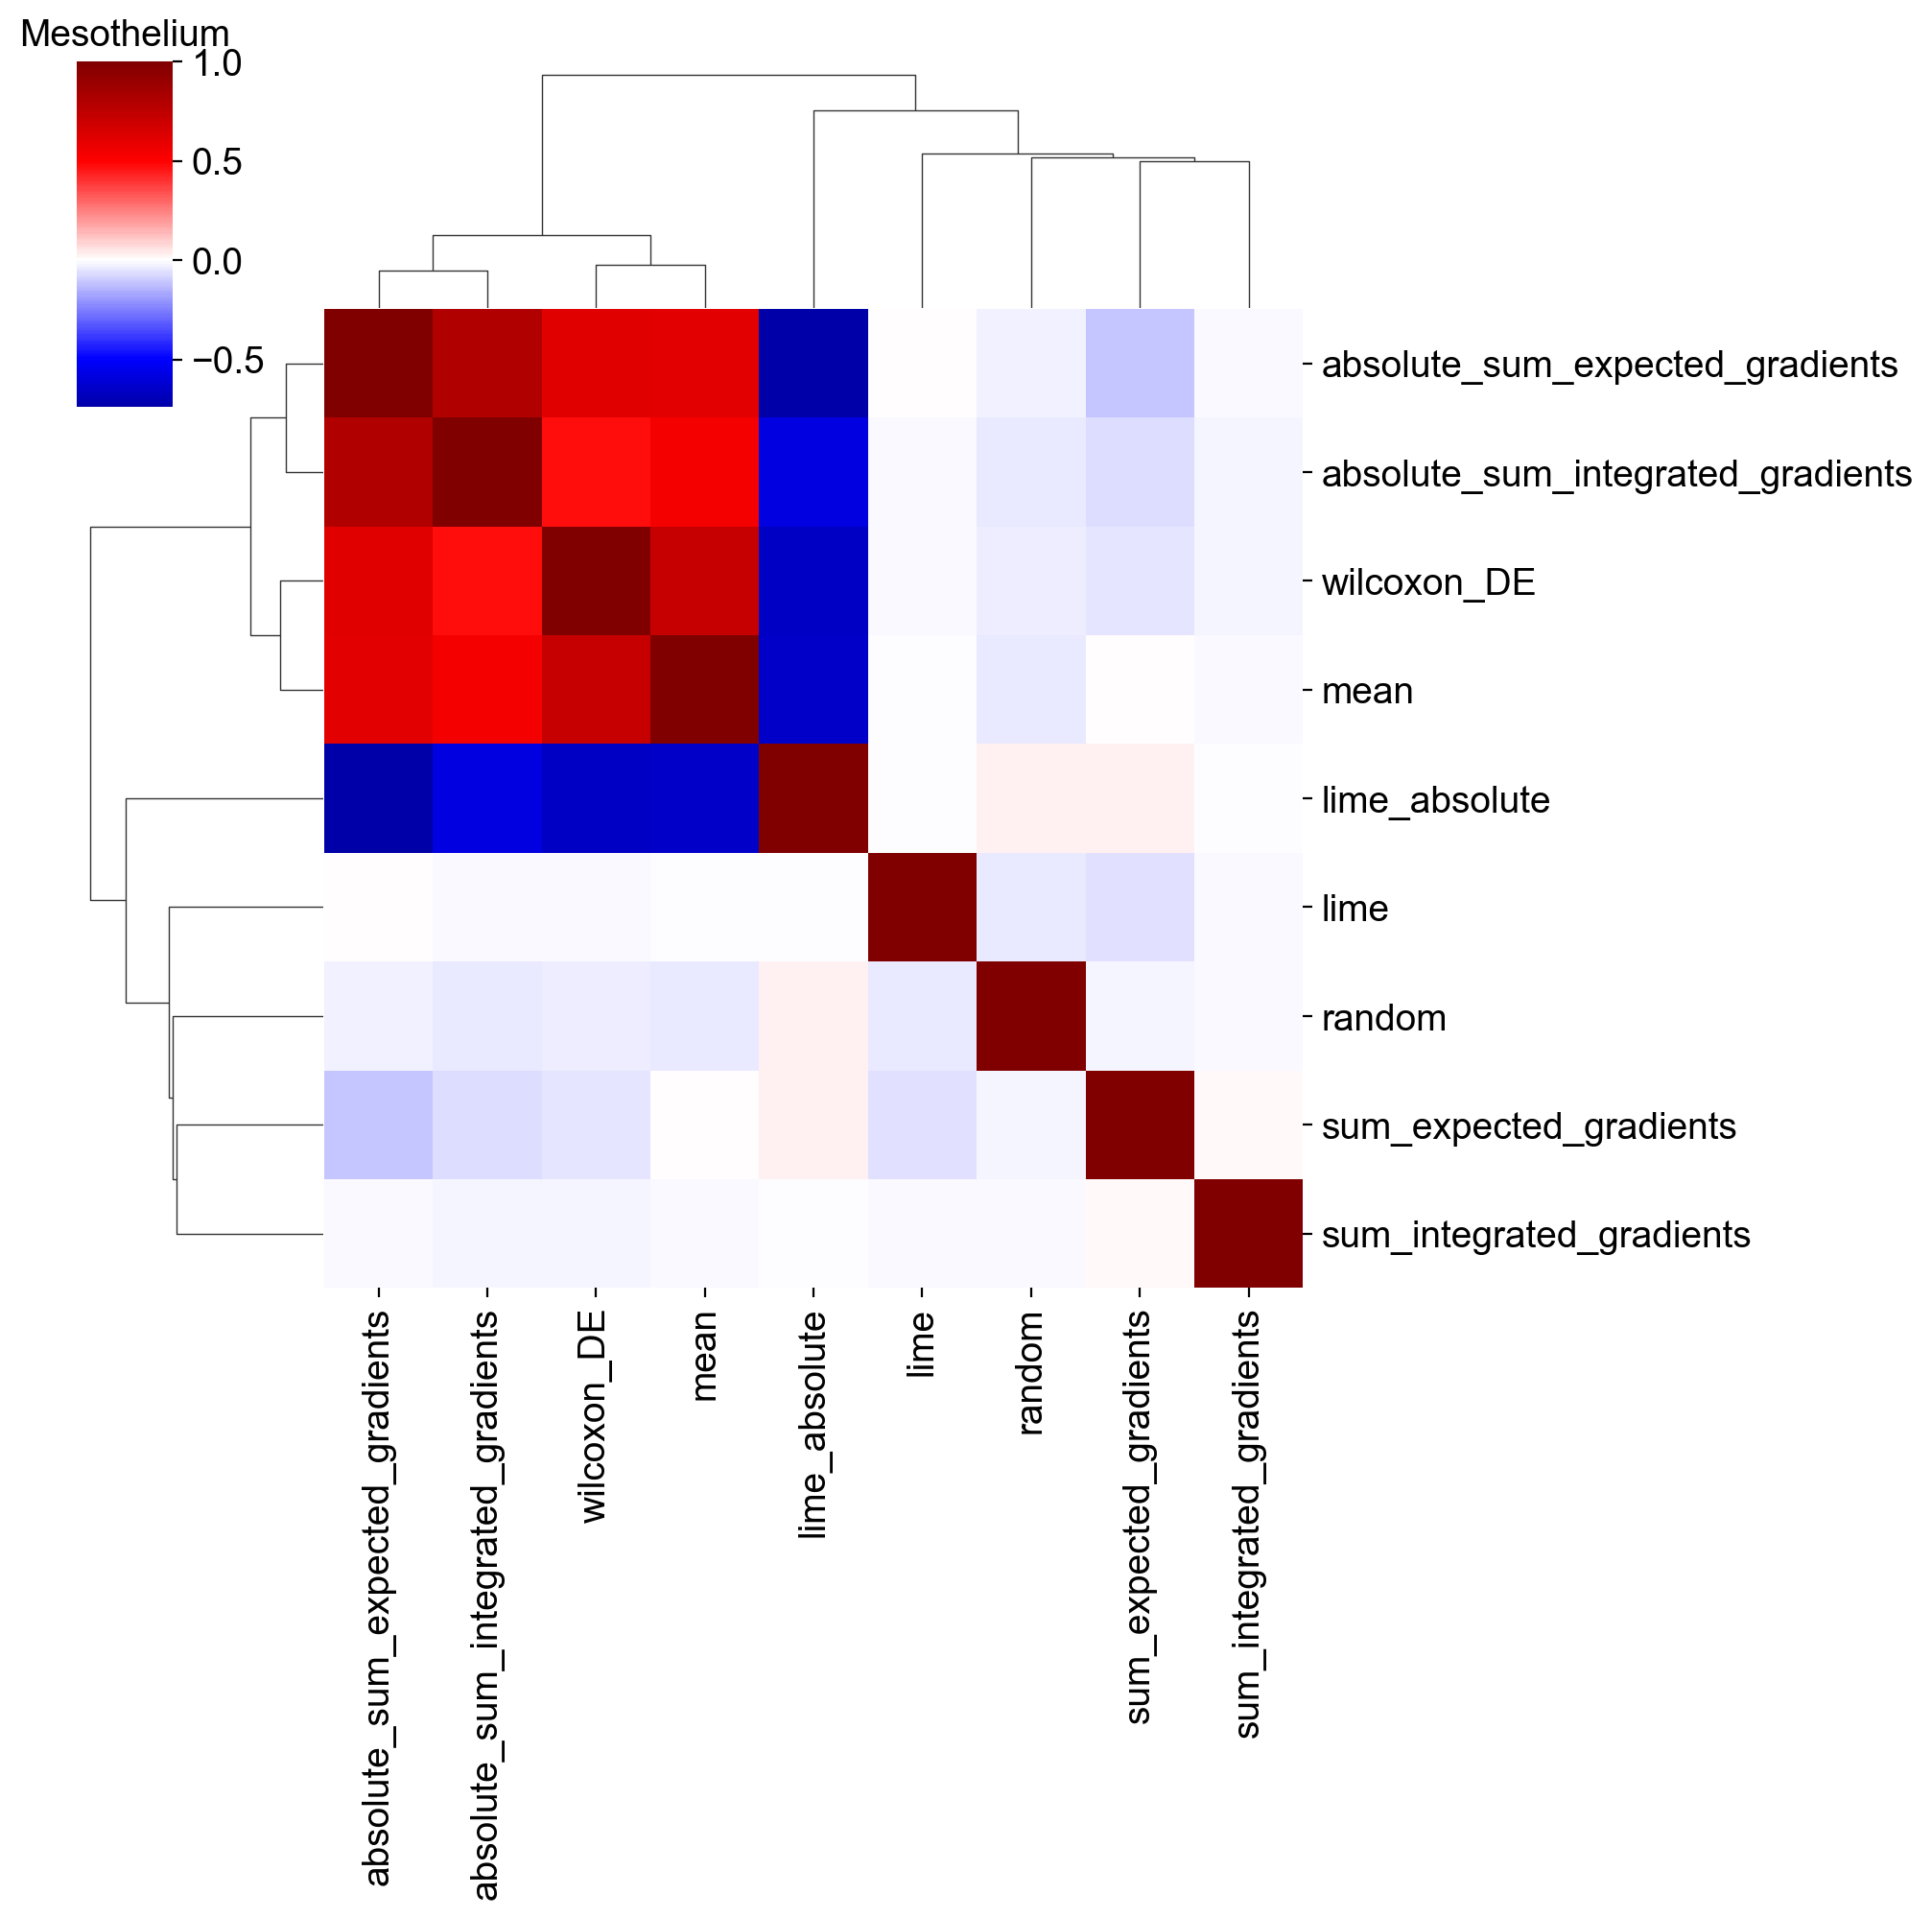

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwa

wilcoxon_DE Monocytes
wilcoxon_DE Neutrophilic
wilcoxon_DE Non-T/B cells
wilcoxon_DE Proliferating cells
wilcoxon_DE Rare
wilcoxon_DE Secretory
wilcoxon_DE Smooth Muscle
wilcoxon_DE Squamous
wilcoxon_DE Submucosal Secretory
wilcoxon_DE T cell lineage
wilcoxon_DE Venous


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


In [61]:
corr_dfs = []
for ct in default_df.columns:
    broken = False
    ct_df = pd.DataFrame(index=list(adata_hlca.var_names),
                          columns=methods_to_paths.keys())
    for method, path in methods_to_paths.items():
        method_df = pd.read_csv(f"../outputs/{path}",
                                index_col=0)
        
        # fix for pvalues being the wrong direction
        if method == 'wilcoxon_DE':
            method_df[:] = -np.log10(method_df)
            method_df.replace(np.Inf, 10000)

        # for when cell types are missing from a df
        try:
            ct_df[method] = method_df[ct]
        except KeyError:
            print(method, ct)
            broken = True
            break
    if broken:
        continue

    ct_df.apply(lambda df: df.abs())
    ct_spearman = ct_df.corr(method="spearman")

    sns.clustermap(ct_spearman, cmap="seismic", center=0.00)
    plt.title(ct)
    plt.show()
    
    corr_dfs.append(ct_spearman)

Take average of correlation values.

In [72]:
arr = np.array([df.values for df in corr_dfs])
mean_corr_df = corr_dfs[0].copy()
mean_corr_df[:] = arr.mean(axis=0)

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/seaborn/matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


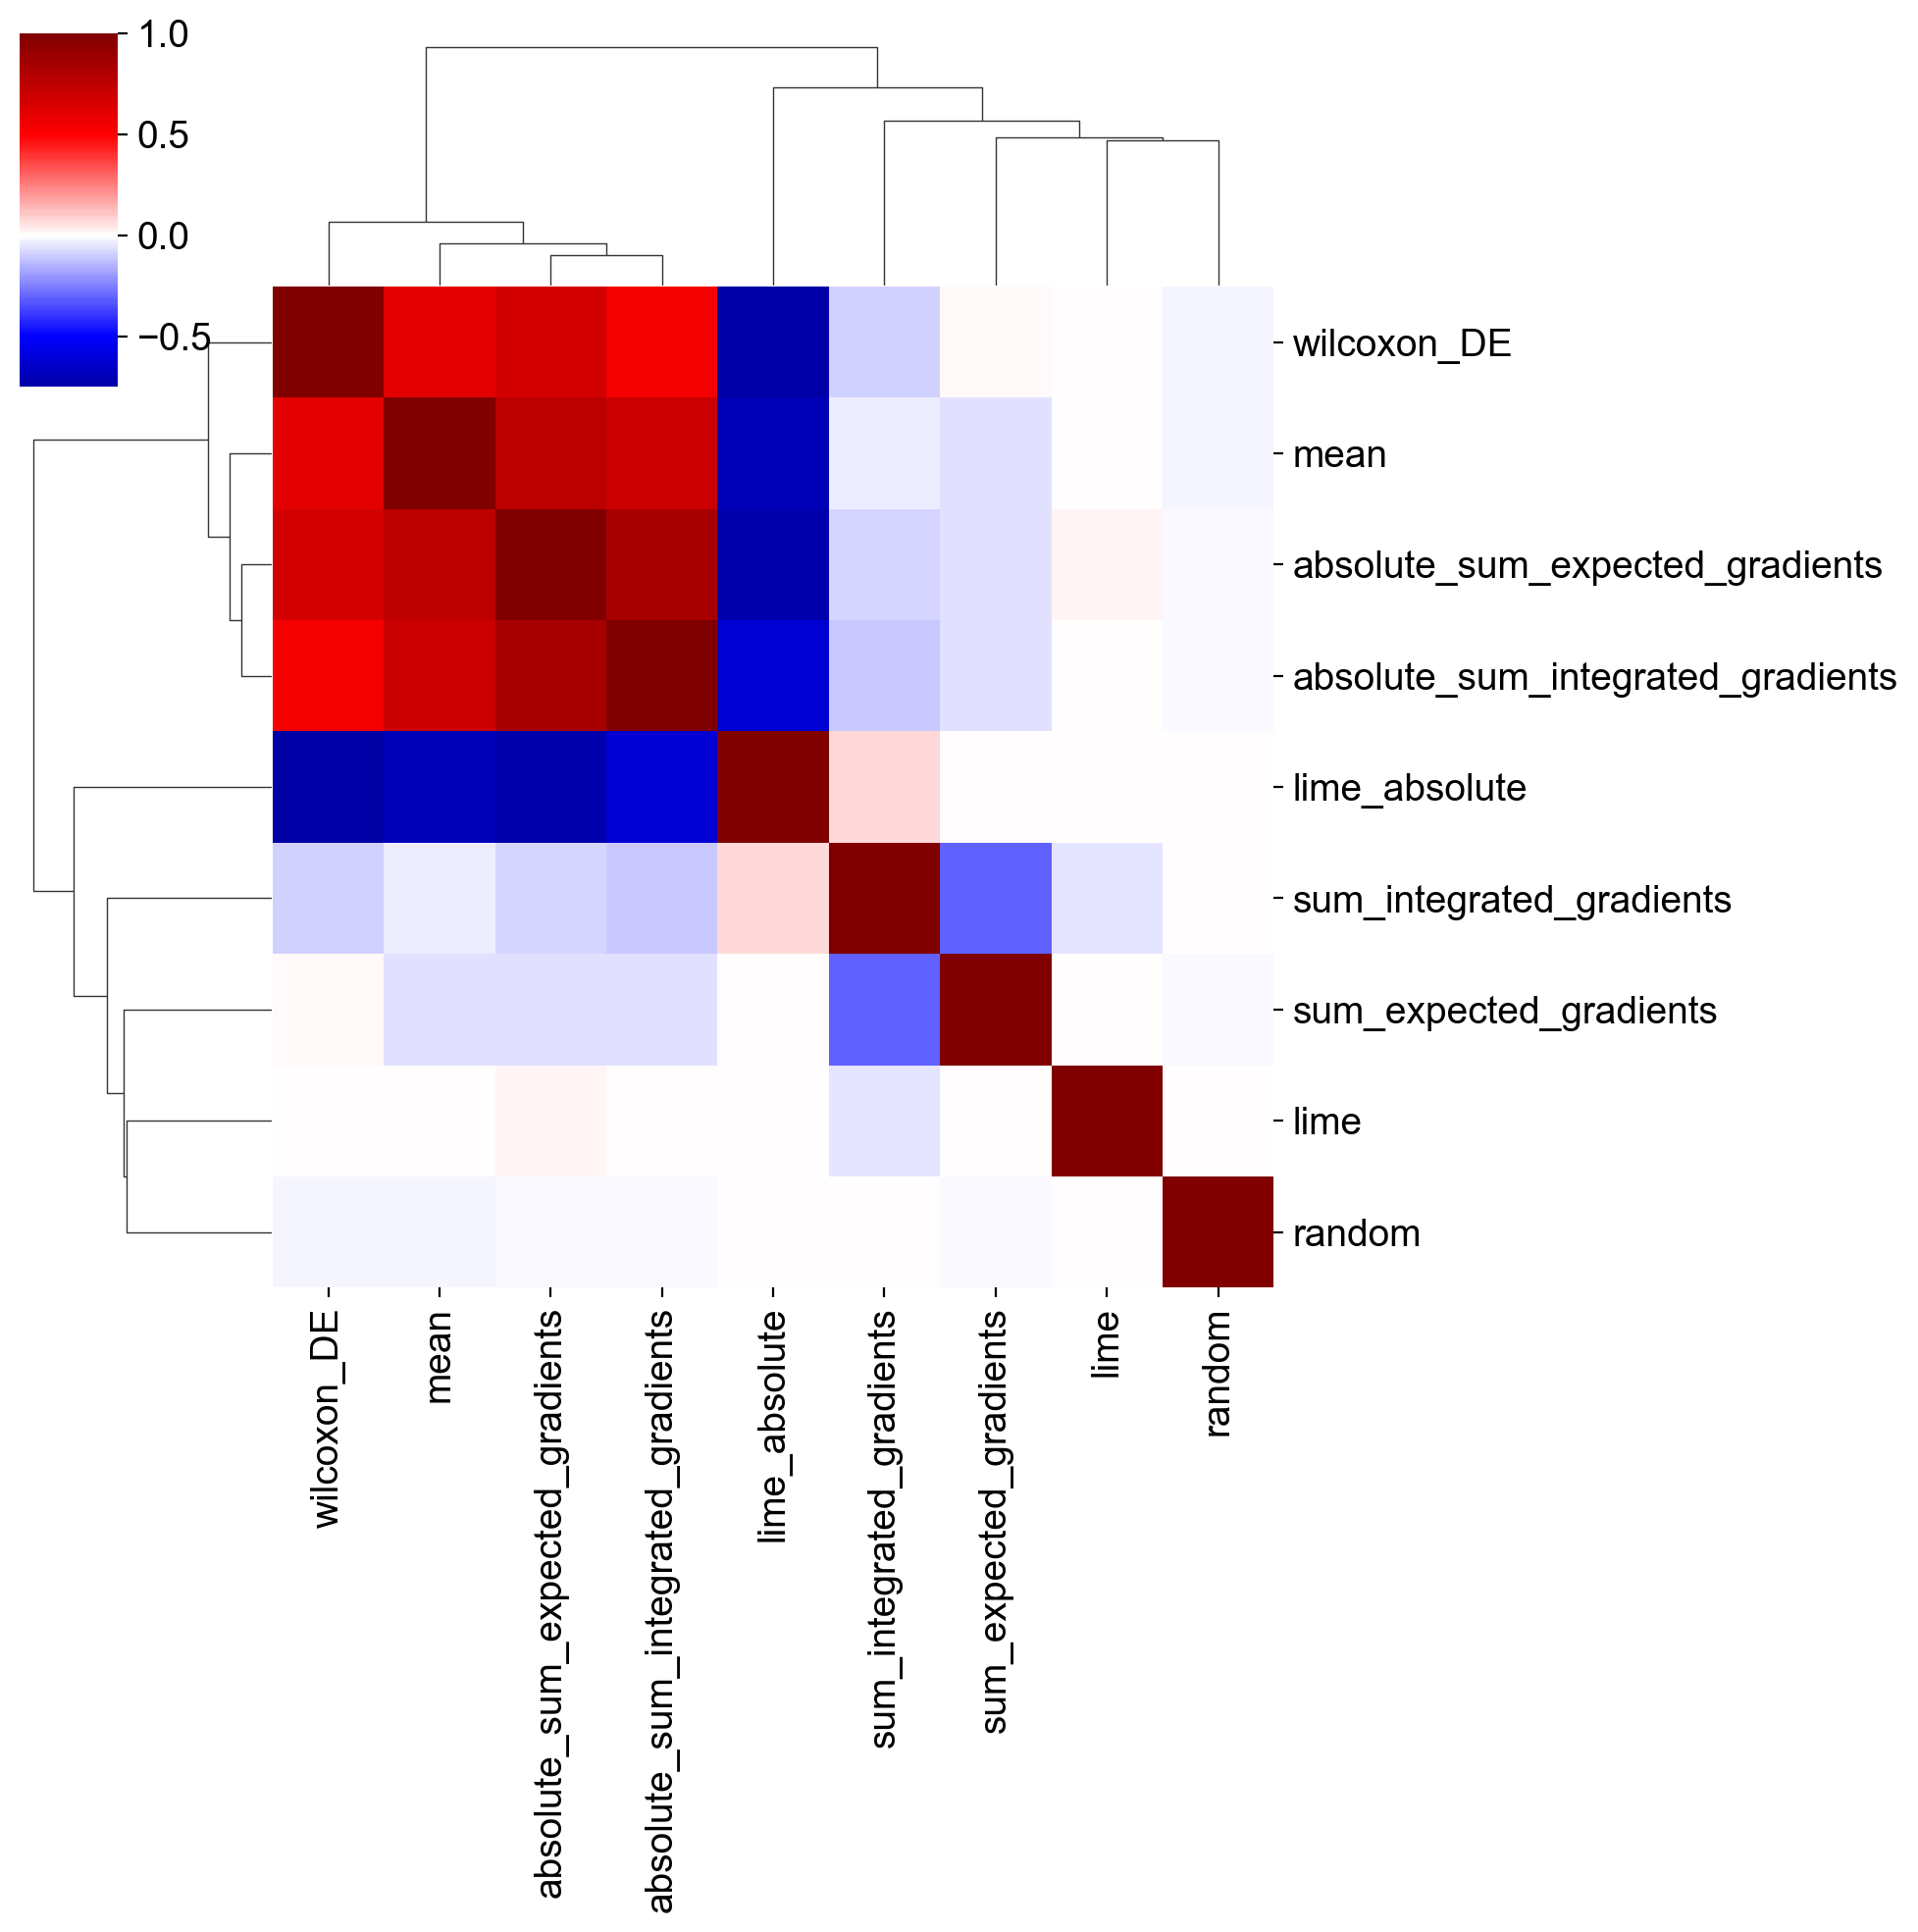

In [73]:
sns.clustermap(mean_corr_df, cmap="seismic", center=0.00)

## OLD STUFF WHERE WE JUST RAN CLUSTERMAP ON THE RAW OUTPUT TABLES

In [31]:
all_files = [os.path.join(path, name) for path, subdirs, files in os.walk("../outputs") for name in files]

all_tables = {}

for path in all_files:
    if "ipynb_checkpoints" not in path:
        table_name = path.split("/")[-1][:-4]
        all_tables[table_name] = path
all_tables

{'task_2_sum_integrated_grads': '../outputs/integrated_gradients/task_2_sum_integrated_grads.csv',
 'task_2_absolute_sum_integrated_grads': '../outputs/integrated_gradients/task_2_absolute_sum_integrated_grads.csv',
 'task_2_absolute_sum_expected_grads': '../outputs/expected_gradients/task_2_absolute_sum_expected_grads.csv',
 'task_2_sum_expected_grads': '../outputs/expected_gradients/task_2_sum_expected_grads.csv',
 'task1_random': '../outputs/random/task1_random.csv',
 'task2_random': '../outputs/random/task2_random.csv',
 'lime': '../outputs/lime/lime.csv',
 'lime_absolute': '../outputs/lime/lime_absolute.csv',
 'norman_DE_rest': '../outputs/differential_expression/norman_DE_rest.csv',
 'hlca_DE_cell_types': '../outputs/differential_expression/hlca_DE_cell_types.csv',
 'norman_DE_control': '../outputs/differential_expression/norman_DE_control.csv'}

task_2_sum_integrated_grads


/home/lukas/anaconda3/envs/yuge_env/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


task_2_absolute_sum_integrated_grads


/home/lukas/anaconda3/envs/yuge_env/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


task_2_absolute_sum_expected_grads


/home/lukas/anaconda3/envs/yuge_env/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


task_2_sum_expected_grads


/home/lukas/anaconda3/envs/yuge_env/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


task1_random


/home/lukas/anaconda3/envs/yuge_env/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


task2_random


/home/lukas/anaconda3/envs/yuge_env/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


lime


/home/lukas/anaconda3/envs/yuge_env/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


lime_absolute


/home/lukas/anaconda3/envs/yuge_env/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


norman_DE_rest


/home/lukas/anaconda3/envs/yuge_env/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


hlca_DE_cell_types


/home/lukas/anaconda3/envs/yuge_env/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


norman_DE_control


/home/lukas/anaconda3/envs/yuge_env/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


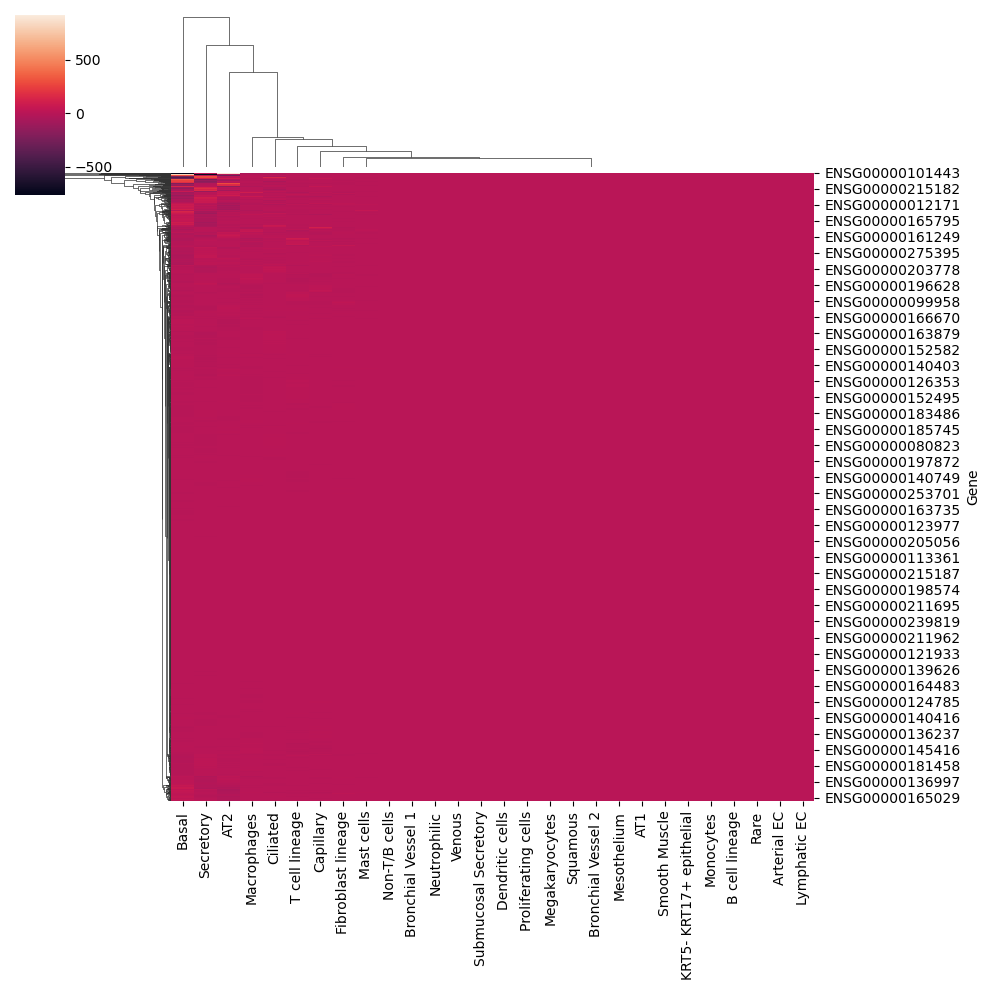

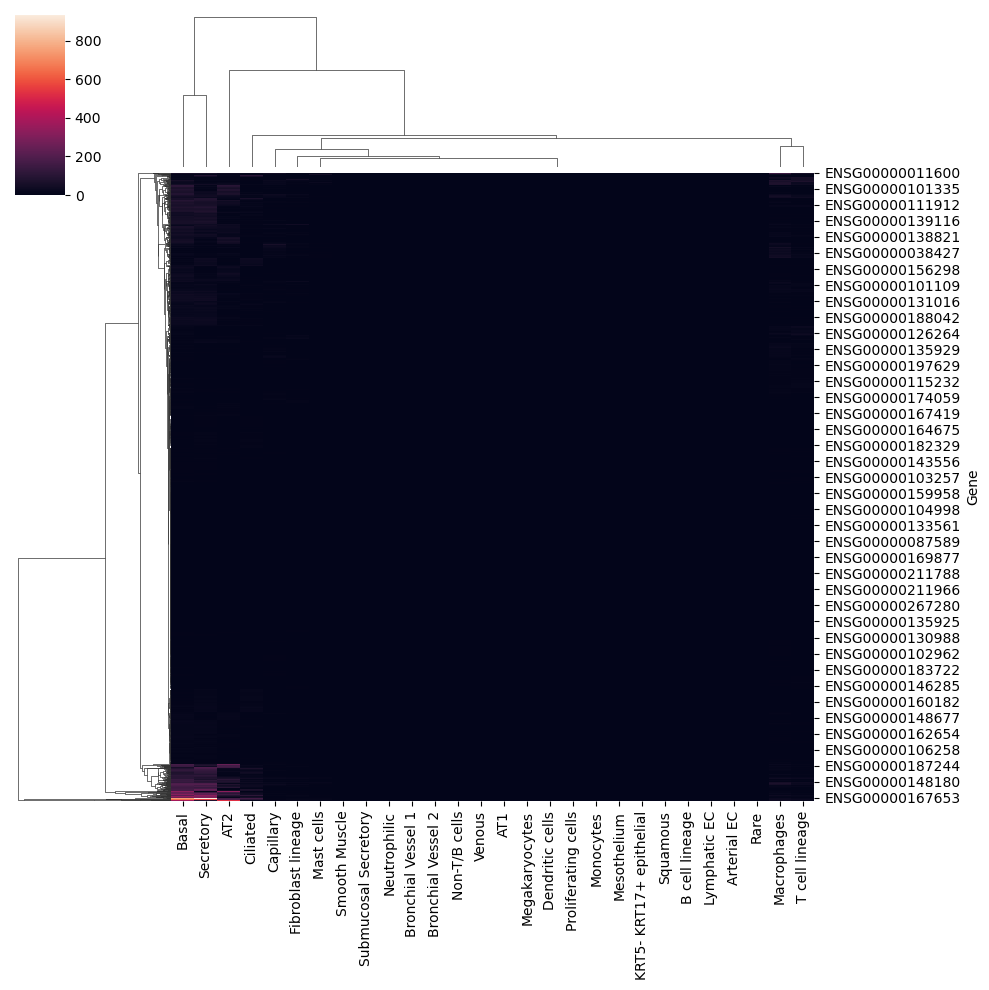

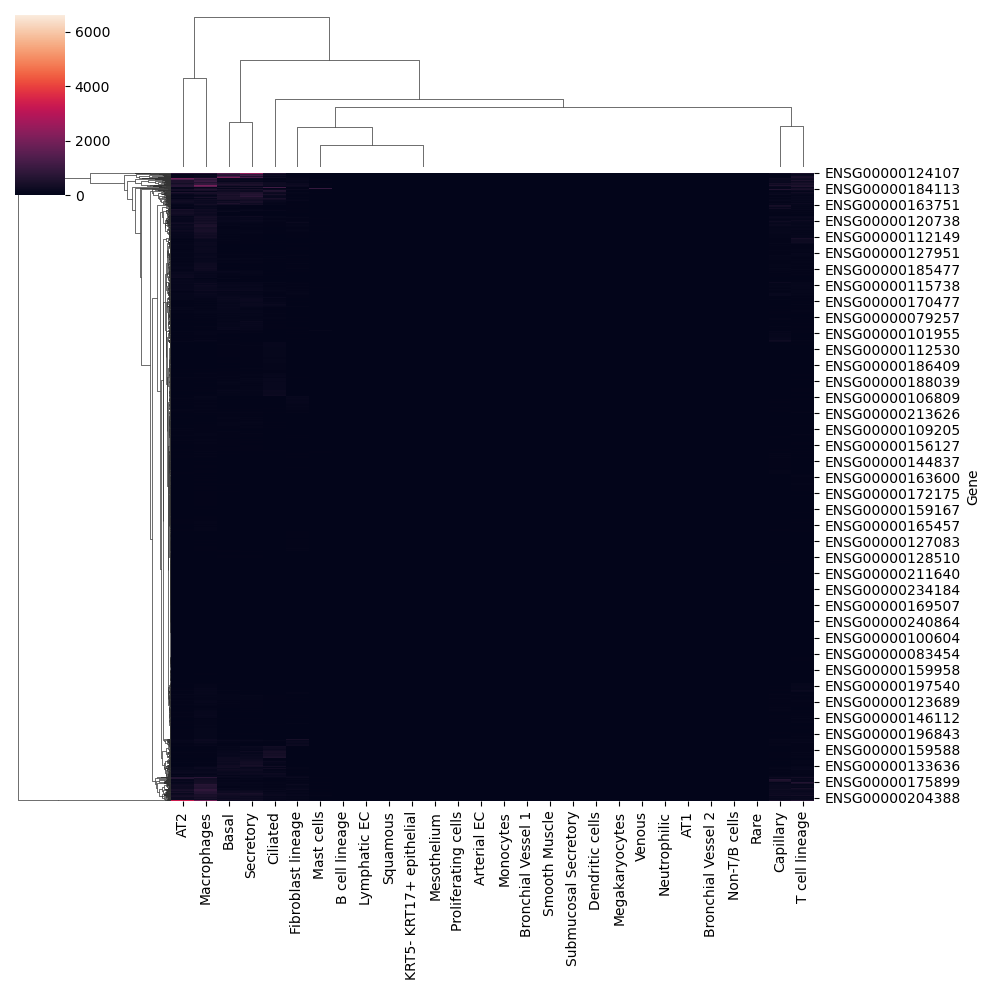

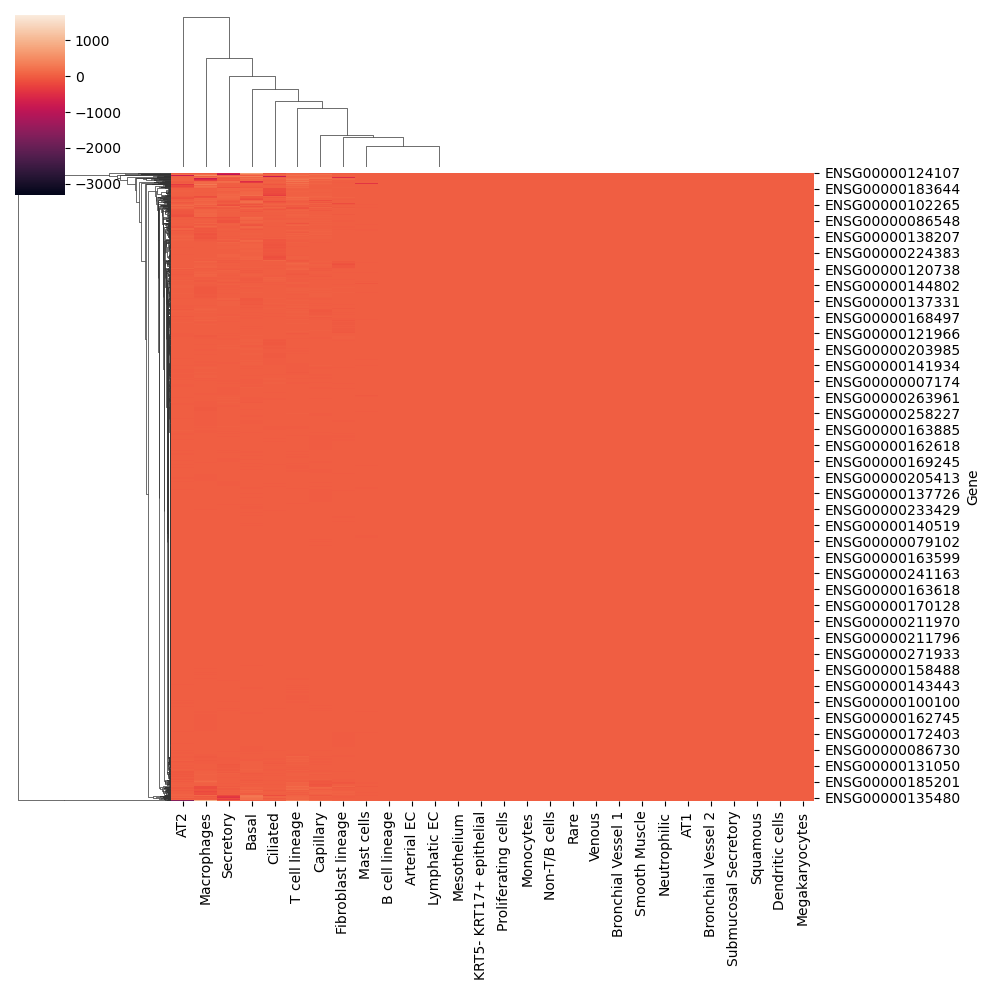

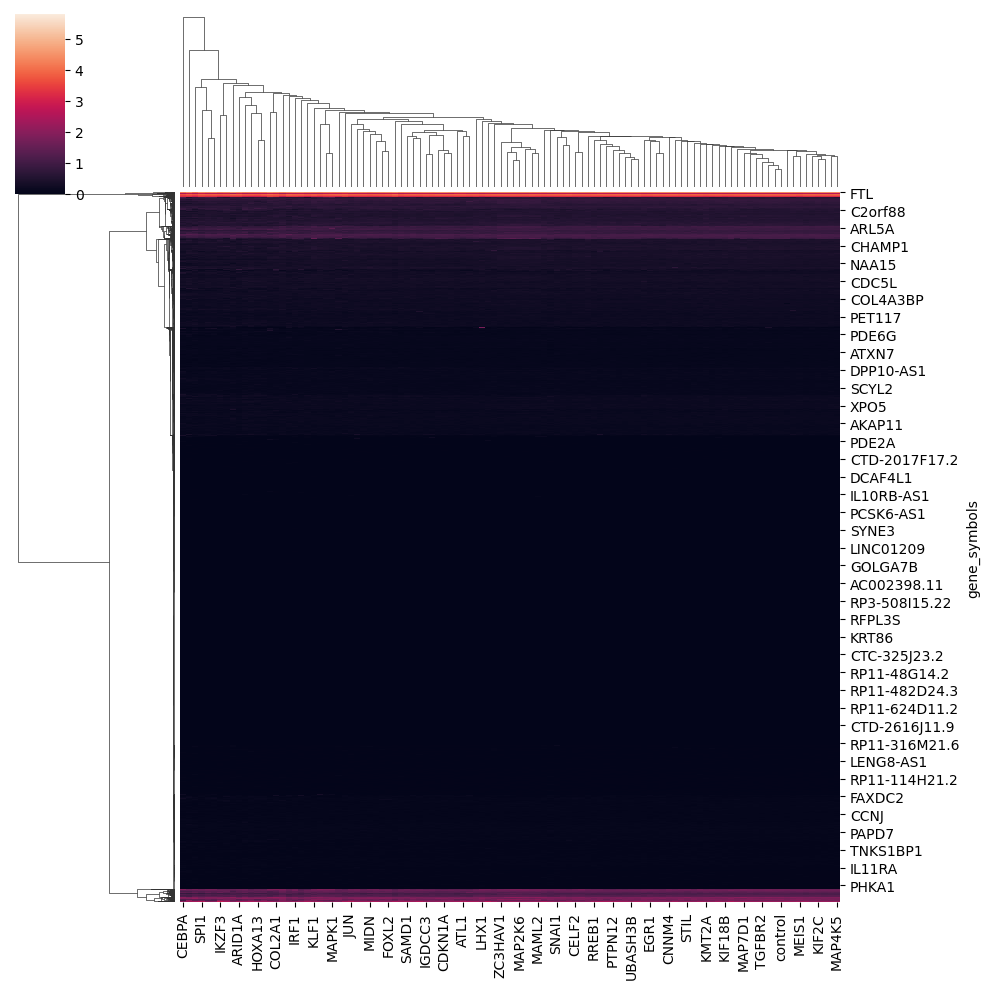

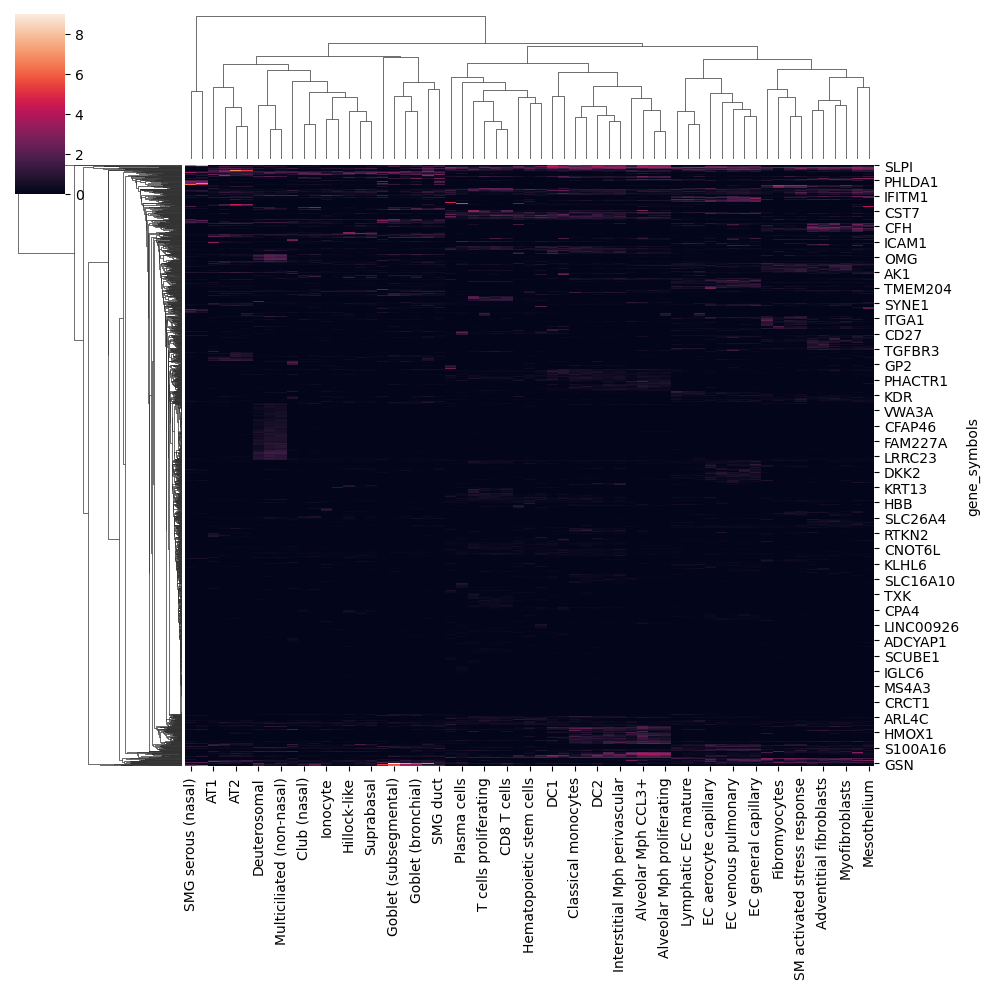

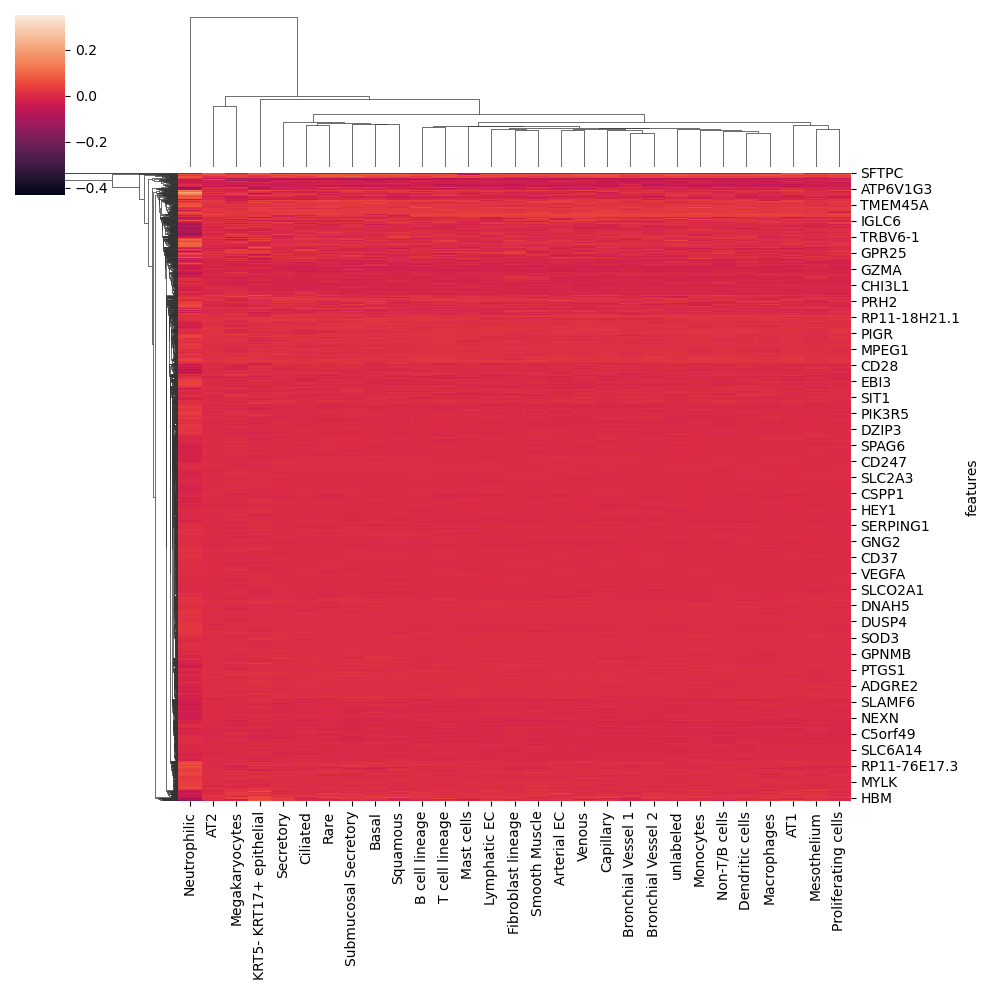

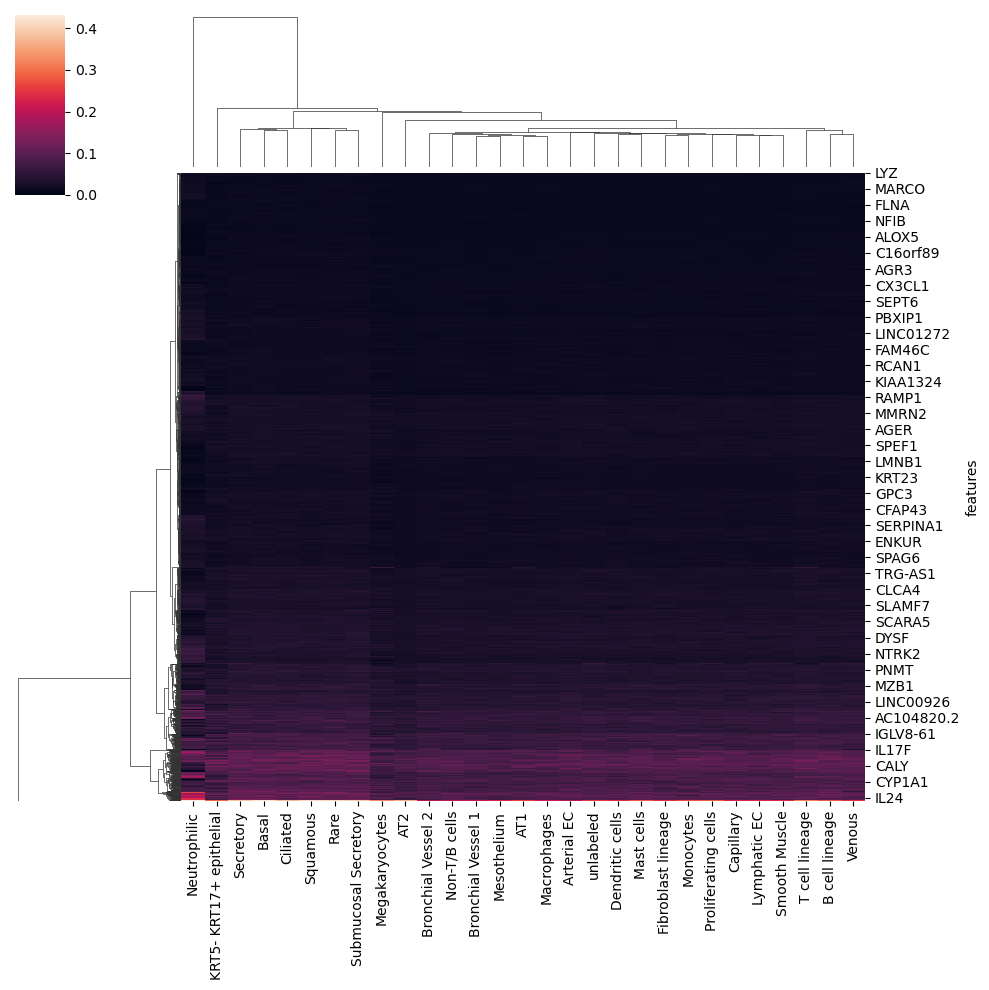

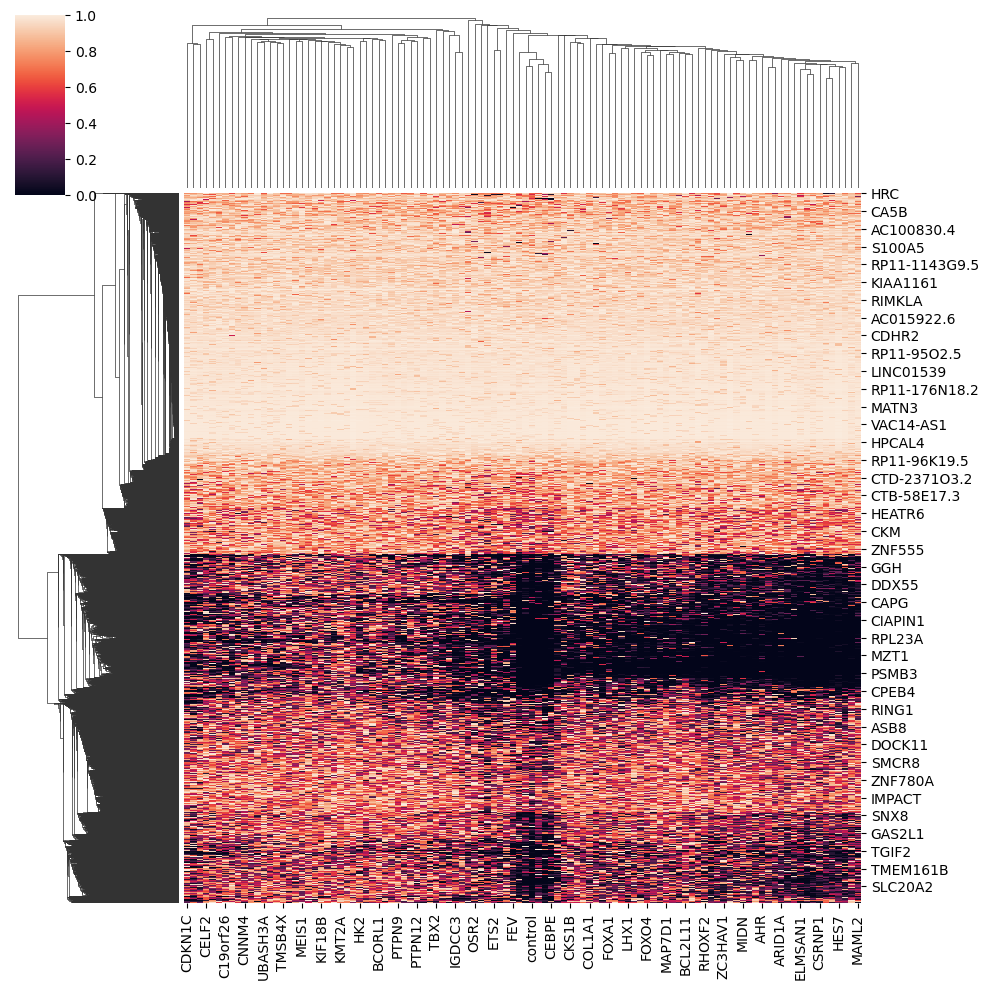

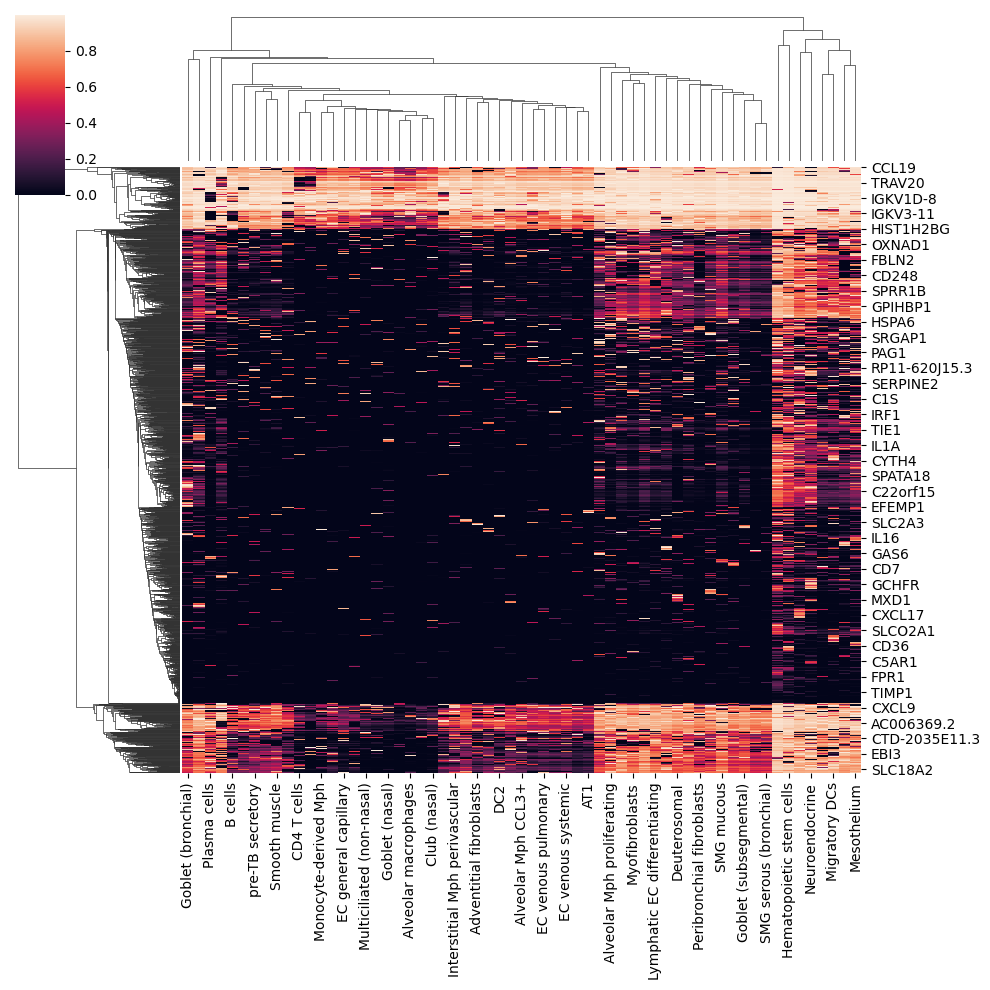

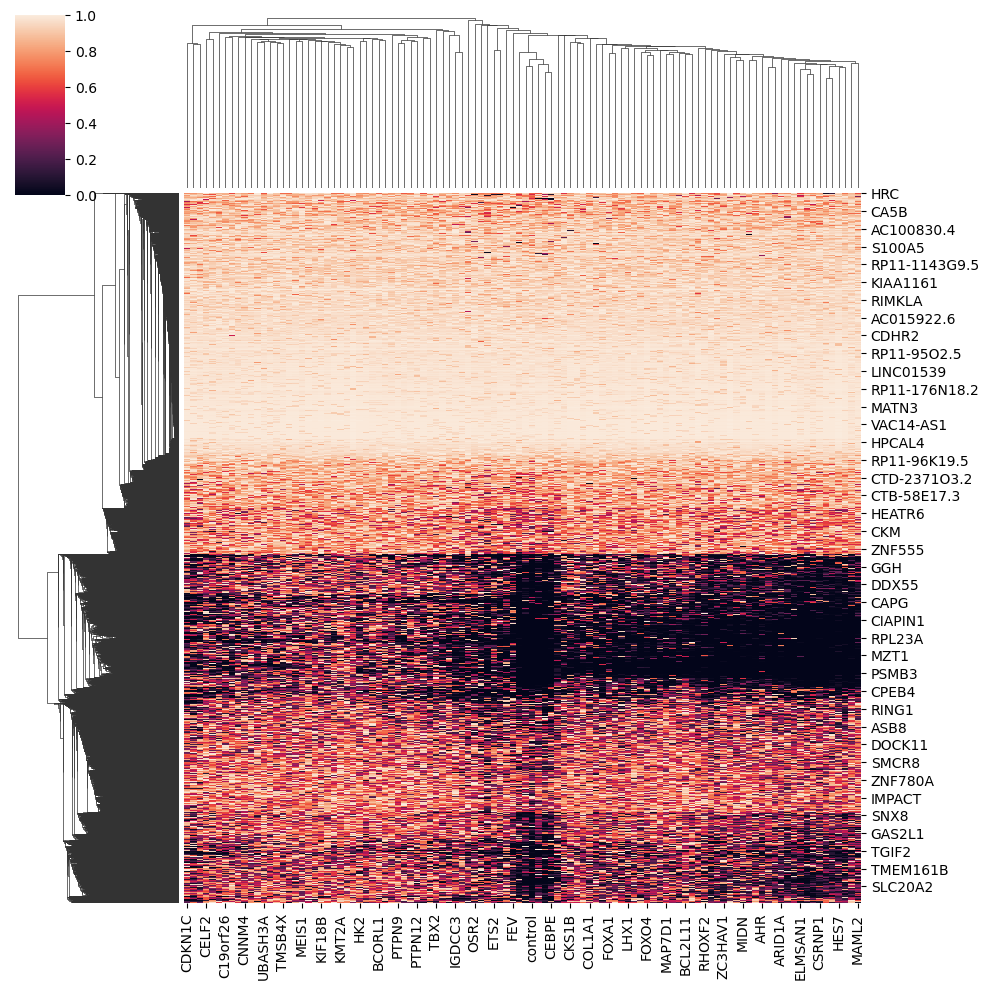

In [35]:
for table, path in all_tables.items():
    df = pd.read_csv(path,
                    index_col=0)
    print(table)
    sns.clustermap(df)